# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

In [1]:
import sys

# setting path
sys.path.append('..')

from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle, os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt
from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle
from statannotations.Annotator import Annotator
from collections import defaultdict
from scipy import stats
import mne
import glob 
import random
import re
import statsmodels.formula.api as smf
import statsmodels as sm
from scipy.stats import spearmanr


from mna.utils.rnapp_data_format import read_all_files
# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
plt.style.use('default')



# Aux functions, read files

In [3]:
# loop over the list of csv files
def read_motor_csvs():
    csv_files = glob.glob(os.path.join(output_dir, "ppid*_motor.csv"))
    all_dfs = None
    for f in csv_files:
        # read the csv file
        if not type(all_dfs)==pd.core.frame.DataFrame:
            all_dfs = pd.read_csv(f)
        else:
            all_dfs = pd.concat([all_dfs, pd.read_csv(f)], ignore_index=True)
    all_dfs = all_dfs[all_dfs.columns.drop(list(all_dfs.filter(regex='Unnamed')))]
    return all_dfs

def get_motor_epochs():
    epochs_files = glob.glob(os.path.join(output_dir, "**/*ica_epochs.pickle"), recursive=True)
    motor_epochs = []
    for each_file in epochs_files:
        motor_epochs.append(pickle.load(open(each_file, 'rb')))
    motor_epochs = mne.concatenate_epochs(motor_epochs)
    for col in ['ppid','session','block','number_in_block','trial']:
        motor_epochs.metadata[col] = motor_epochs.metadata[col].astype(int)
    return motor_epochs

def get_motor_intensity_info(input_df):
    
    def str_list_to_list(lst):
        str_single_space = re.sub("\s+", " ", lst.strip())
        str_no_brackets = re.sub("[\[\]]", "", lst)
        return [float(n) for n in str_no_brackets.split()]
    
    try:
        all_steer_events = input_df['post_steer_event_raw']
        all_steer_events_finalized = all_steer_events.apply(str_list_to_list)
    except:
        all_steer_events_finalized = input_df['post_steer_event_raw']
    norm_pos = lambda wheel_pos: np.asarray(wheel_pos)/np.asarray(wheel_pos[0])
    final_pos = lambda final_wheel_pos: np.asarray(final_wheel_pos[-1])-np.asarray(final_wheel_pos[0])

    norm_pos_df = all_steer_events_finalized.apply(norm_pos)
    final_pos_df = abs(all_steer_events_finalized.apply(final_pos))
    input_df["Steer_Wheel_Degree"] = abs(all_steer_events_finalized.apply(final_pos))
    all_dfs = []
    for sub in input_df.ppid.unique():
        sub_df = input_df[input_df.ppid==sub]
        sub_df["Steer_Wheel_Degree_Categorical"] = pd.qcut(sub_df.Steer_Wheel_Degree, 2, labels=["Low", "High"]) #2=High, 1 =Low
        sub_df["Steer_Wheel_Degree_Encoded"] = sub_df.Steer_Wheel_Degree_Categorical.replace({'High': 2, 'Low': 1})
        all_dfs.append(sub_df)
    return pd.concat(all_dfs).reset_index(drop=True)


def str_list_to_list(lst):
    str_single_space = re.sub("\s+", " ", lst.strip())
    str_no_brackets = re.sub("[\[\]]", "", lst)
    return [float(n) for n in str_no_brackets.split()]

In [6]:
output_dir = '../output/batch_analysis_non_baseline_non_averaged/'
remove_sessions = [(13,1),(15,1),(22,1),(22,102)]
rel_regions = {'premotor_regions': ['FC3', 'FC1', 'FCz', 'FC2', 'FC4'], 'dorsolateral_prefrontal': ['AF3', 'AFz', 'AF4'], 'intermediate_frontal': ['F3', 'F1', 'Fz', 'F2', 'F4']}
all_regions = sum(rel_regions.values(),[])

pupil_df = pd.read_csv(f"../output/pupil_exposure/participant_level_exposure_fits.csv")
# trial_dfs = pd.read_csv(f"{output_dir}all_results.csv")
motor_dfs = read_motor_csvs()
motor_dfs['post_steer_event_raw'] = motor_dfs['post_steer_event_raw'].apply(str_list_to_list)
motor_epochs = get_motor_epochs()

Adding metadata with 77 columns
6905 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)


In [5]:
print(pupil_df[['sub','w_opacities','const','p_opacities']].to_latex(index=False,float_format="{:0.2f}".format))

\begin{tabular}{rrrr}
\toprule
 sub &  w\_opacities &  const &  p\_opacities \\
\midrule
  12 &        -0.05 &  -0.09 &         0.00 \\
  13 &        -0.60 &  -0.48 &         0.00 \\
  14 &        -0.30 &  -0.01 &         0.00 \\
  15 &        -0.28 &  -0.37 &         0.00 \\
  16 &        -0.59 &   0.21 &         0.00 \\
  17 &        -0.35 &  -0.18 &         0.00 \\
  18 &        -0.26 &  -0.05 &         0.00 \\
  19 &        -0.15 &   0.11 &         0.20 \\
  20 &        -0.06 &  -0.20 &         0.54 \\
  21 &        -0.04 &  -0.11 &         0.52 \\
  23 &        -0.40 &   1.39 &         0.00 \\
\bottomrule
\end{tabular}



# Clean up dfs

In [6]:
# seaborn
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

motor_outlier_cols = ['abs_sum_delta_steer_input']
cols_to_outlier_detect = ['bpm','sdnn', 'rmssd','pnn50']
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 

def clean_up_trials(input_df):
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block','trial'])
    # nan, outliers
    #for col in motor_outlier_cols:
    #    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    #all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']

    
    all_dfs_final['throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input/all_dfs_final.abs_sum_delta_brake_input
    return all_dfs_final

trial_dfs = clean_up_trials(trial_dfs)
trial_dfs = trial_dfs.loc[~trial_dfs.ppid_session.isin([f"{es[0]}_{es[1]}" for es in remove_sessions])]

motor_dfs = clean_up_trials(motor_dfs)

# luminance effect removal from pupil diameter
trial_dfs['Raw Left Pupil Diameter'] = trial_dfs['Left Pupil Diameter']
motor_dfs['Raw Left Pupil Diameter'] = motor_dfs['Left Pupil Diameter']
p_val_criteria = 0.05
for index, row in trial_dfs.reset_index(drop=True).iloc[1:].iterrows():
    last_ppid = trial_dfs.iloc[index-1].ppid
    last_session = trial_dfs.iloc[index-1].session
    last_trial = trial_dfs.iloc[index-1].trial
    last_opacity = trial_dfs.iloc[index-1].density
    if ((row.ppid == last_ppid) & (row.session == last_session) & (row.trial == last_trial+1)): # if continuous
        # if there is a significant effect of opacity on pupil
        if pupil_df.loc[pupil_df['sub']==last_ppid,'p_opacities'].values < p_val_criteria:
            this_opacity = row.density
            this_pupil_diameter = row['Left Pupil Diameter']
            weight = pupil_df.loc[pupil_df['sub']==last_ppid,'w_opacities']
            adjustment = (this_opacity-last_opacity)*weight
            trial_dfs.iloc[index,trial_dfs.columns.get_loc('Left Pupil Diameter')] -= adjustment
            motor_dfs.loc[(motor_dfs.ppid == last_ppid) & (motor_dfs.session == last_session) & (motor_dfs.trial == last_trial+1),'Left Pupil Diameter'] -= adjustment # update motor df too
            motor_epochs.metadata.loc[(motor_epochs.metadata.ppid == last_ppid) &
                                      (motor_epochs.metadata.session == last_session) &
                                      (motor_epochs.metadata.trial == last_trial+1),'Left Pupil Diameter'] += adjustment # update motor epochs too
# pupil bins
motor_dfs['pupil_bin'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))
trial_dfs['pupil_bin'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))
motor_epochs.metadata['pupil_bin'] = motor_epochs.metadata.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))
motor_dfs['pupil_bin_encoded'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=[0,1]))
trial_dfs['pupil_bin_encoded'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=[0,1]))
motor_epochs.metadata['pupil_bin_encoded'] = motor_epochs.metadata.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=[0,1]))

In [7]:
preturn = 1000
motor_epochs.apply_baseline((-(preturn/1000),-((preturn-250)/1000)))

# participant-level binning of motor data, replaces the session-level info already there
motor_dfs = get_motor_intensity_info(motor_dfs) 
motor_epochs.metadata = get_motor_intensity_info(motor_epochs.metadata)

Applying baseline correction (mode: mean)
Replacing existing metadata with 72 columns


# Descriptives

## Trial level

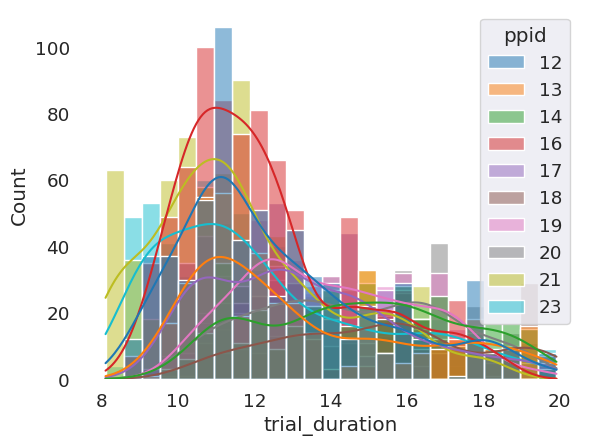

In [7]:
sns.histplot(data=motor_dfs, x="trial_duration", kde=True,hue='ppid',palette = 'tab10')
plt.box(False)

## Pupil Distributions

[(0.0, 0.8),
 Text(0.5, 36.72222222222221, 'Trial opacity'),
 Text(50.847222222222214, 0.5, 'Adjusted Pupil Diameter')]

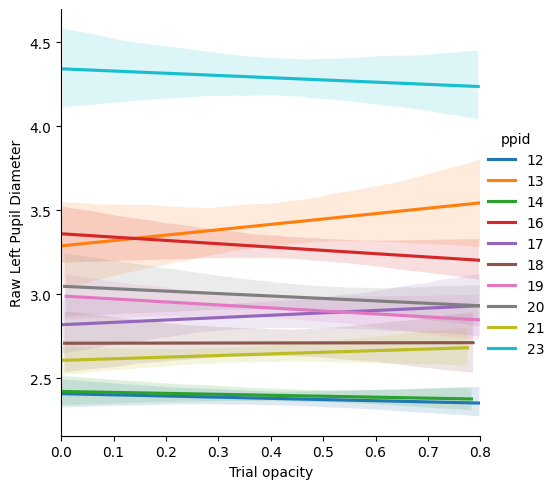

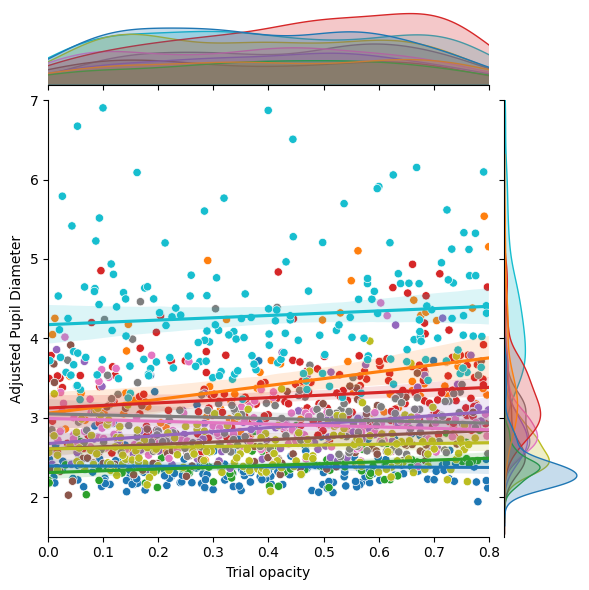

In [43]:
plt.style.use('default')


g=sns.lmplot(data = trial_dfs, x='density',y='Raw Left Pupil Diameter',scatter=False,hue='ppid',palette = 'tab10')
g.set(xlim=(0, 0.8),xlabel='Trial opacity')


g = sns.jointplot(data=trial_dfs, x='density',y='Left Pupil Diameter', hue='ppid',palette = 'tab10',legend=False,xlim=(0,0.8),ylim=(1.5,7))
g.ax_joint.set_xlabel('Trial opacity')

for _,gr in trial_dfs.groupby('ppid'):
    h = sns.regplot(x='density',y='Left Pupil Diameter', data=gr, scatter=False, ax=g.ax_joint, truncate=False)
h.set(xlim=(0, 0.8),xlabel='Trial opacity',ylabel='Adjusted Pupil Diameter')

<AxesSubplot:xlabel='Motor intensity'>

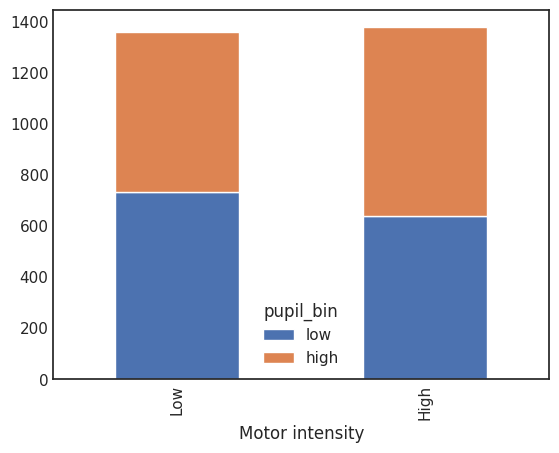

In [21]:
%matplotlib inline
sns.set(font_scale=1)
plt.style.use('seaborn-white')

#motor_dfs_stacked = trial_dfs.groupby(['spoken_difficulty', 'pupil_bin']).size().reset_index().pivot(columns='pupil_bin', index='spoken_difficulty', values=0)
#motor_dfs_stacked.plot(kind='bar', stacked=True)
motor_dfs_stacked = motor_dfs.groupby(['Steer_Wheel_Degree_Categorical', 'pupil_bin']).size().reset_index().pivot(columns='pupil_bin', index='Steer_Wheel_Degree_Categorical', values=0)
motor_dfs_stacked.plot(kind='bar', stacked=True,xlabel='Motor intensity')


## Motor Data

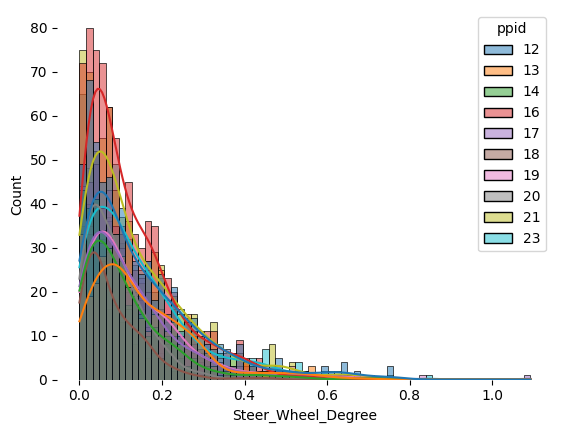

In [10]:
sns.histplot(data=motor_dfs, x="Steer_Wheel_Degree", kde=True,hue='ppid',palette = 'tab10')
plt.box(False)

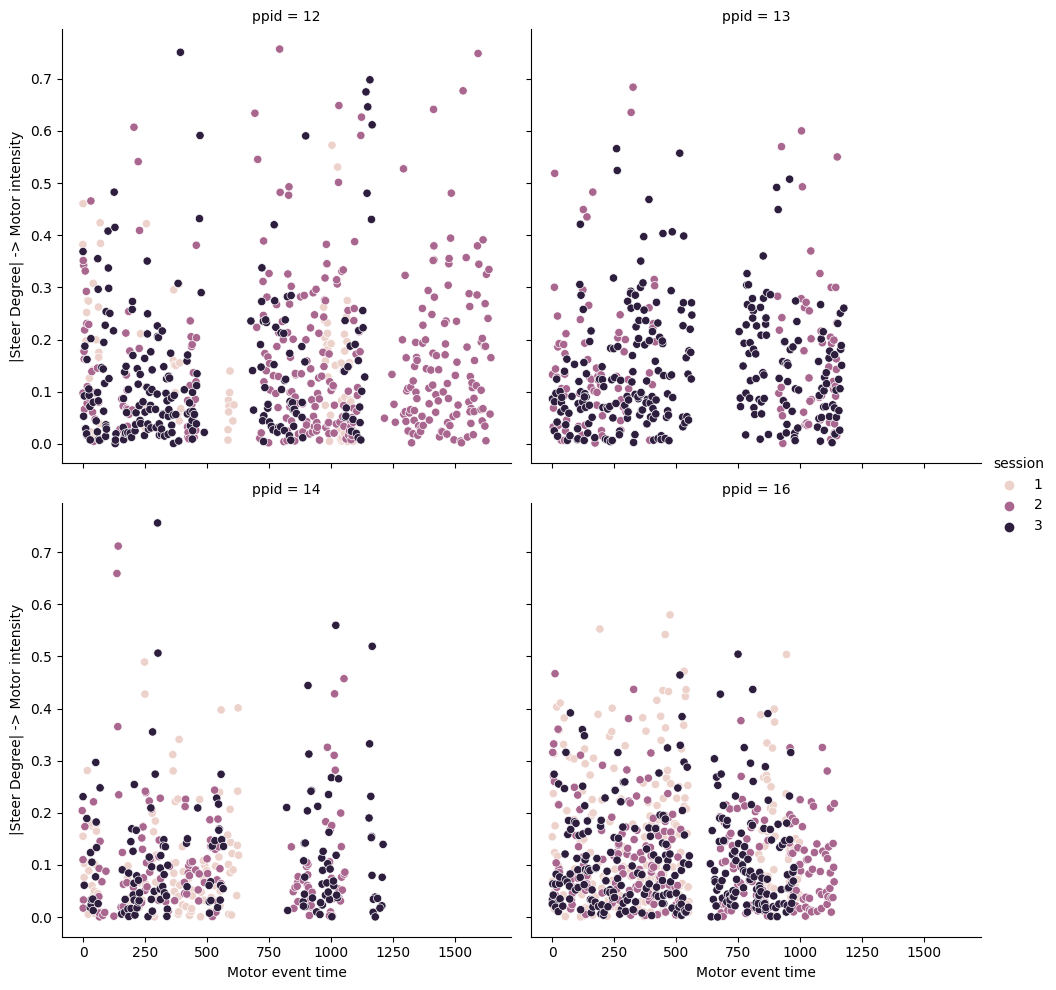

In [11]:
motor_dfs['referenced_motor_start'] = motor_dfs.groupby(['ppid','session'])['trial_start_time'].transform(
                     lambda x: x-x.iloc[0])
g = sns.relplot(data=motor_dfs[motor_dfs.ppid.isin([12,13,14,16])],x='referenced_motor_start',y='Abs_Steer_Wheel_Degree',
            hue='session',kind='scatter',col='ppid',col_wrap=2)
g.set_ylabels("|Steer Degree| -> Motor intensity", clear_inner=False)
g.set_xlabels("Motor event time", clear_inner=False)

### Turns sample

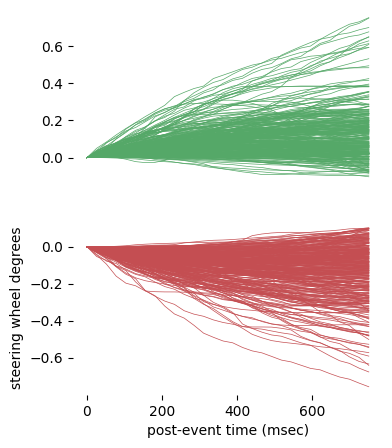

In [12]:
plt.style.use('default')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
# note that wheel is at 40Hz effectively
plt.subplot(211)

for i, row in motor_dfs.loc[(motor_dfs.ppid==12)].iterrows():
    if row['turn_type']=='right':
        baseline_adjust = np.array(row['post_steer_event_raw'])-row['post_steer_event_raw'][0]
        plt.plot(np.linspace(start=0, stop=30/40*1000, num=30), baseline_adjust, color="g", linewidth=.5)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
plt.box(False)

plt.subplot(212)

        
for i, row in motor_dfs.loc[(motor_dfs.ppid==12)].iterrows():
    if row['turn_type']=='left':
        baseline_adjust = np.array(row['post_steer_event_raw'])-row['post_steer_event_raw'][0]
        plt.plot(np.linspace(start=0, stop=30/40*1000, num=30),baseline_adjust, color="r", linewidth=.5)
    plt.xlabel("post-event time (msec)")
    plt.ylabel("steering wheel degrees")

plt.box(False)


# EEG Epochs

## Evoked data by motor intensity

In [ ]:
evokeds_iterable = dict()

query = "Steer_Wheel_Degree_Categorical == '{}'"

for cond in motor_epochs.metadata['Steer_Wheel_Degree_Categorical'].unique():
    evokeds_iterable[str(cond)] = list(motor_epochs[query.format(cond)].iter_evoked())
low_motor = motor_epochs[query.format('Low')]
high_motor = motor_epochs[query.format('High')]
low_pupil = motor_epochs["pupil_bin == '{}'".format('low')]
high_pupil =motor_epochs["pupil_bin == '{}'".format('high')]

## Significance test by region

In [68]:
time_windows = []
all_times = list(np.linspace(-1,0,100))
for index, t in enumerate(all_times):
    if index > 0:
        time_windows.append((all_times[index-1], all_times[index]))

### Motor decisions


Targeted statistical test results:


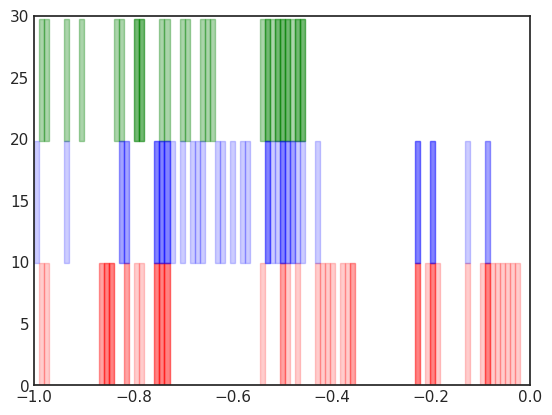

In [ ]:
#time_windows = ((-1.000,-.750), (-.75, 0))
elecs = all_regions
df_index = ['condition', 'epoch', 'time']

report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")
#low_motor=low_pupil
#high_motor = high_pupil
fig, ax = plt.subplots()
ax.plot()
region_dict = {'premotor_regions': [0,'red'], 'intermediate_frontal': [.33,'blue'], 'dorsolateral_prefrontal': [.66,'green']}
for time_idx, (tmin, tmax) in enumerate(time_windows):
    long_df = high_motor.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    short_df = low_motor.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    for elec in elecs:
        # extract data
        A = long_df[elec]
        B = short_df[elec]

        # conduct t test
        t, p = stats.ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(motor_epochs.events) - 2, t_val=t, p=p)
        if p < 0.05:
            for index,e in enumerate(list(rel_regions.values())):
                if elec in e:
                    region = list(rel_regions.keys())[index]
                    ax.axvspan(tmin, tmax, ymin=region_dict[region][0], ymax=region_dict[region][0]+.33, alpha=1/len(rel_regions[region]), color=region_dict[region][1])
            # print(report.format(**format_dict))
ax.set_xlim([all_times[0], all_times[-1]])
ax.set_ylim([0, 30])
plt.show()

### Pupil diameter


Targeted statistical test results:


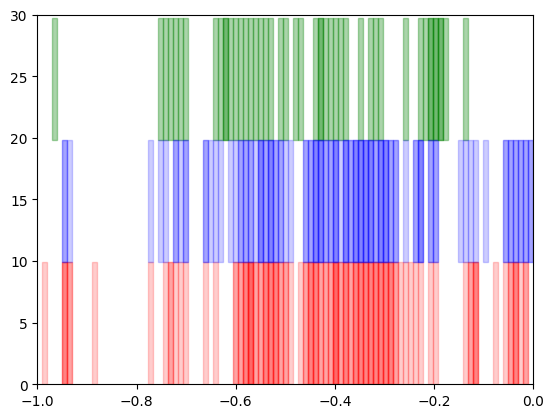

In [16]:
#time_windows = ((-1.000,-.750), (-.75, 0))
elecs = all_regions
df_index = ['condition', 'epoch', 'time']

report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")
fig, ax = plt.subplots()
ax.plot()
region_dict = {'premotor_regions': [0,'red'], 'intermediate_frontal': [.33,'blue'], 'dorsolateral_prefrontal': [.66,'green']}
for time_idx, (tmin, tmax) in enumerate(time_windows):
    long_df = high_pupil.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    short_df = low_pupil.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    for elec in elecs:
        # extract data
        A = long_df[elec]
        B = short_df[elec]
        # conduct t test
        t, p = stats.ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(motor_epochs.events) - 2, t_val=t, p=p)
        if p < 0.05:
            for index,e in enumerate(list(rel_regions.values())):
                if elec in e:
                    region = list(rel_regions.keys())[index]
                    ax.axvspan(tmin, tmax, ymin=region_dict[region][0], ymax=region_dict[region][0]+.33, alpha=1/len(rel_regions[region]), color=region_dict[region][1])
            # print(report.format(**format_dict))
ax.set_xlim([all_times[0], all_times[-1]])
ax.set_ylim([0, 30])
plt.show()

No projector specified for this dataset. Please consider the method self.add_proj.


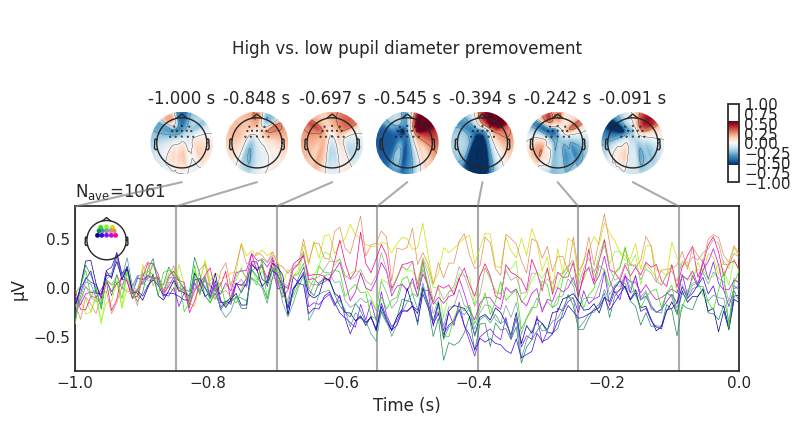

combining channels using "mean"
combining channels using "mean"


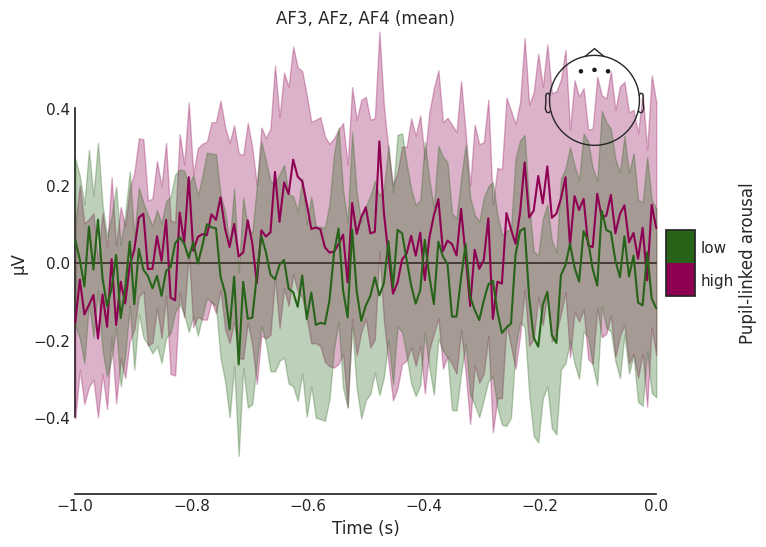

combining channels using "mean"
combining channels using "mean"


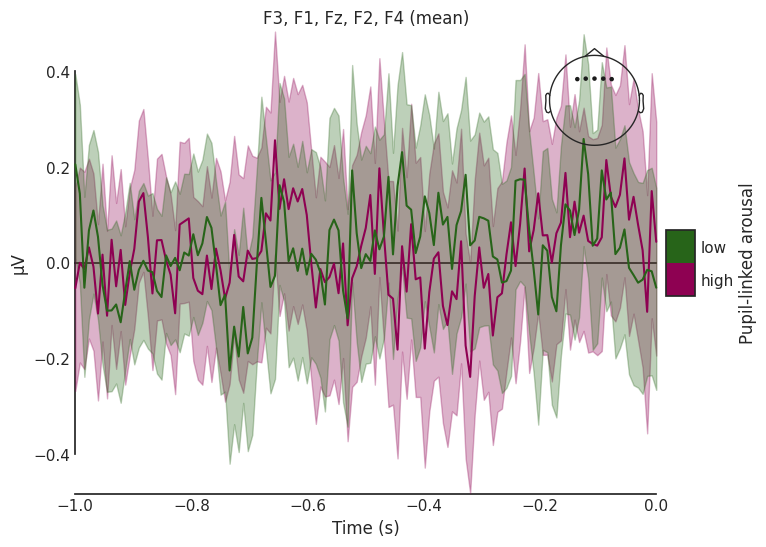

combining channels using "mean"
combining channels using "mean"


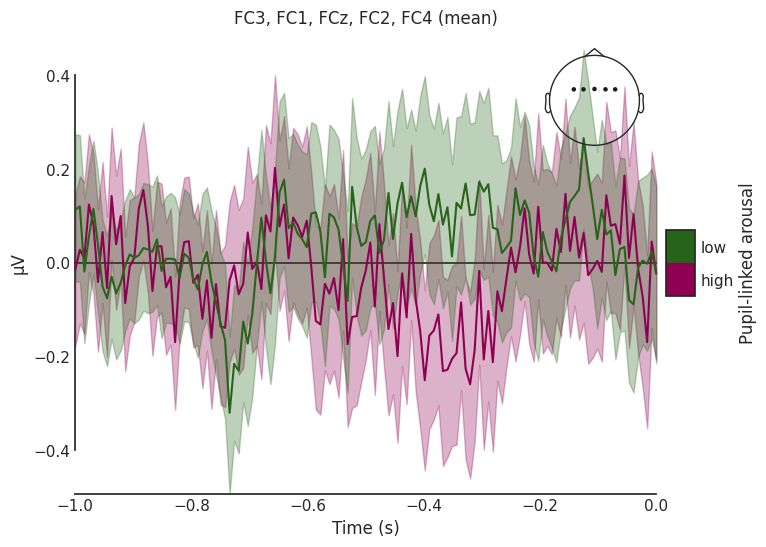

[<Figure size 800x600 with 3 Axes>]

In [154]:
query = "pupil_bin == '{}'"
evokeds_iterable_pup={}
for cond in ['high', 'low']: # ignore nan
    evokeds_iterable_pup[str(cond)] = list(motor_epochs[query.format(cond)].iter_evoked())


# We need an evoked object to plot the image to be masked
evoked_comb = mne.combine_evoked([high_pupil.average(), low_pupil.average()],
                            weights=[1, -1])
time_unit = dict(time_unit="s")
evoked_comb.plot_joint(times=all_times[::15],title="High vs. low pupil diameter premovement", ts_args=time_unit,
                  topomap_args=time_unit,picks=all_regions)  # show difference wave


mne.viz.plot_compare_evokeds(evokeds_iterable_pup, cmap=('Pupil-linked arousal', 'PiYG'),
                             picks=rel_regions['dorsolateral_prefrontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable_pup, cmap=('Pupil-linked arousal', 'PiYG'),
                             picks=rel_regions['intermediate_frontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable_pup, cmap=('Pupil-linked arousal', 'PiYG'),
                             picks=rel_regions['premotor_regions'],combine='mean', show_sensors=True)

### Average difference between conditions (evoked) and by region

No projector specified for this dataset. Please consider the method self.add_proj.


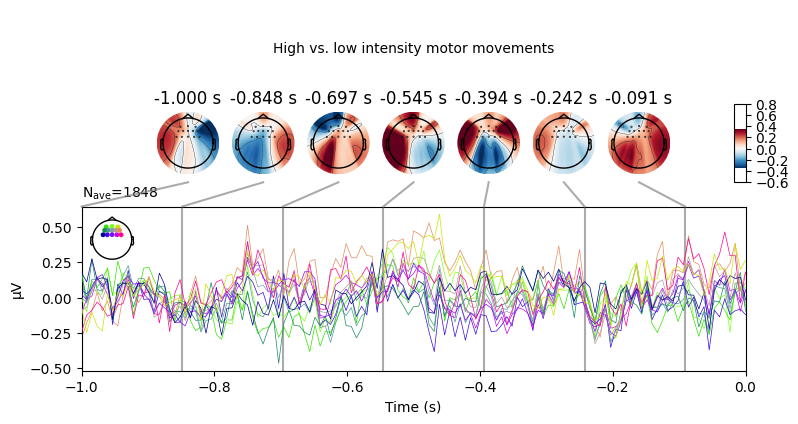

combining channels using "mean"
combining channels using "mean"


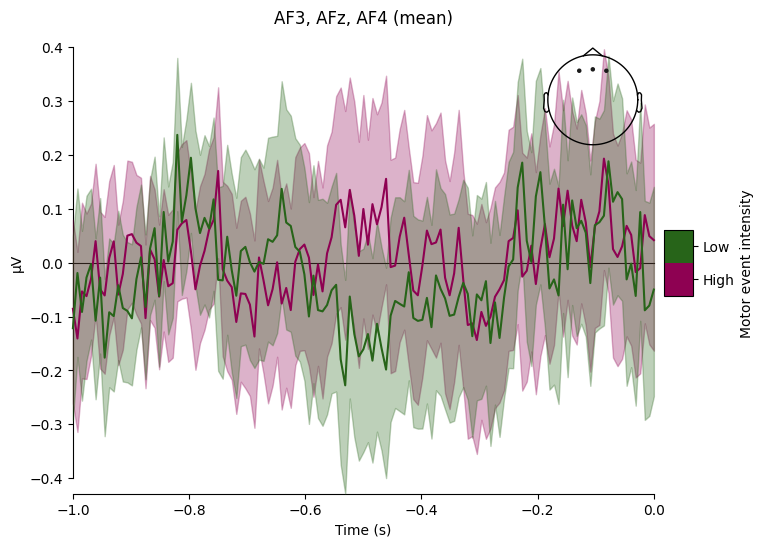

combining channels using "mean"
combining channels using "mean"


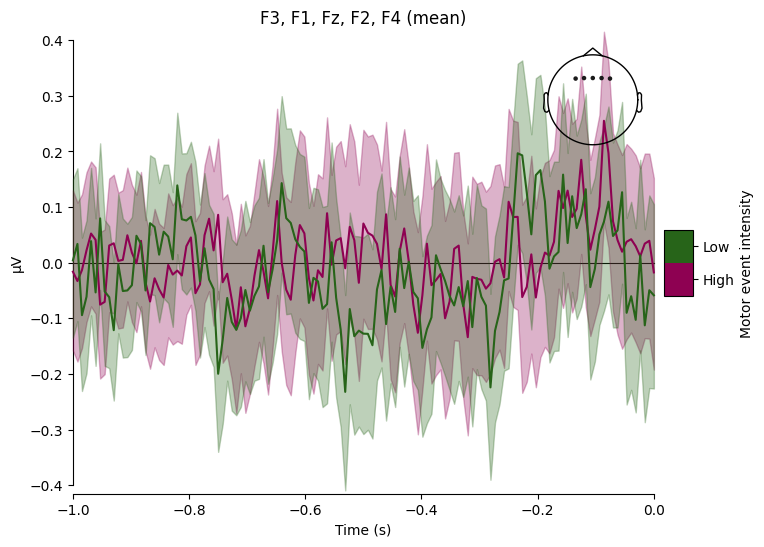

combining channels using "mean"
combining channels using "mean"


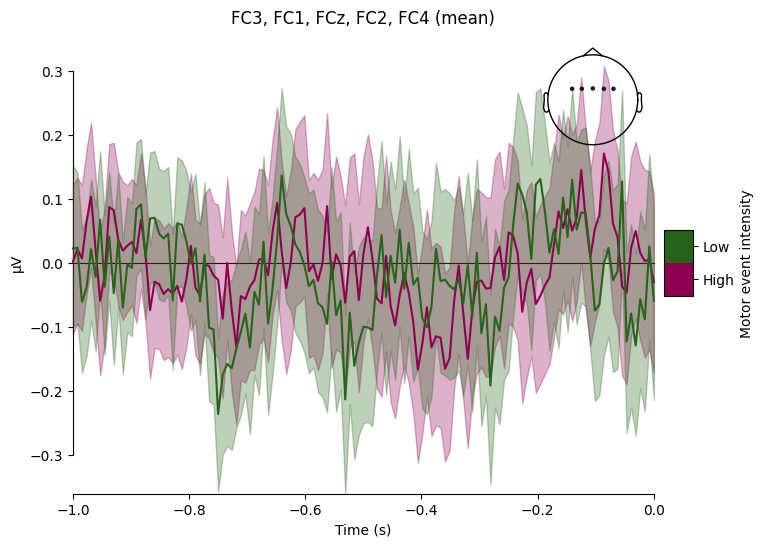

[<Figure size 800x600 with 3 Axes>]

In [17]:
%matplotlib inline


# We need an evoked object to plot the image to be masked
evoked_comb = mne.combine_evoked([high_motor.average(), low_motor.average()],
                            weights=[1, -1])
time_unit = dict(time_unit="s")
evoked_comb.plot_joint(times=all_times[::15],title="High vs. low intensity motor movements", ts_args=time_unit,
                  topomap_args=time_unit,picks=all_regions)  # show difference wave


mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['dorsolateral_prefrontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['intermediate_frontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['premotor_regions'],combine='mean', show_sensors=True)

In [18]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch


# freq_range = np.logspace(*np.log10([4, 55]), num=15)
freq_range = np.linspace(4, 56, 28)
n_cycles = freq_range / 2.

power_diff = tfr_morlet(mne.combine_evoked([high_motor.average(), low_motor.average()],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)
power_diff_motor = tfr_morlet(mne.combine_evoked([high_motor.average(picks=rel_regions['premotor_regions']),
                                                            low_motor.average(picks=rel_regions['premotor_regions'])],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)
power_diff_dlpfc = tfr_morlet(mne.combine_evoked([high_motor.average(picks=rel_regions['dorsolateral_prefrontal']),
                                                            low_motor.average(picks=rel_regions['dorsolateral_prefrontal'])],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)
power_diff_if = tfr_morlet(mne.combine_evoked([high_motor.average(picks=rel_regions['intermediate_frontal']),
                                                            low_motor.average(picks=rel_regions['intermediate_frontal'])],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Applying baseline correction (mode: logratio)


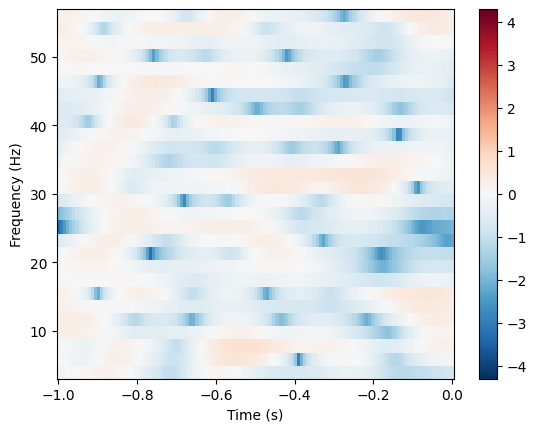

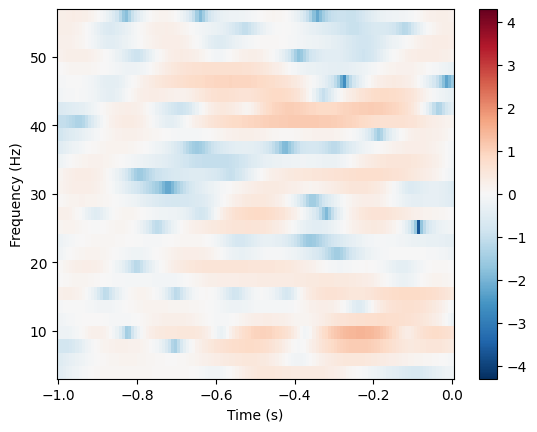

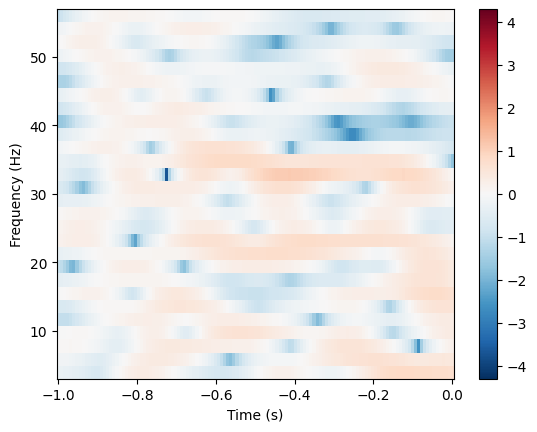

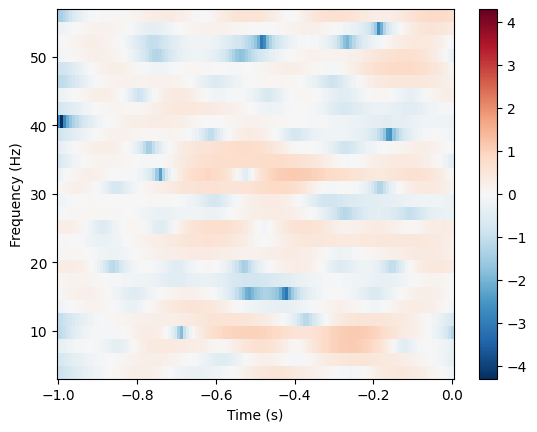

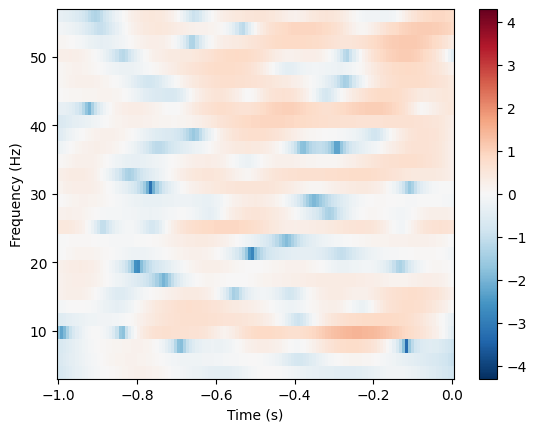

In [19]:
# to plot joint plots
#power_diff.plot(baseline=(-1,-.8),mode='logratio', tmin=-1, tmax=0, 
#                 timefreqs=[(-0.75, 15), (-.5, 30), (-.25, 10)])

# power_diff_dlpfc.plot(baseline=(-1,-.75),mode='logratio', tmin=-1, tmax=0)


# power_diff_if.plot(baseline=(-1,-.75),mode='logratio', tmin=-1, tmax=0)

figs = power_diff_motor.plot(baseline=(-1,-.75),mode='logratio', tmin=-1, tmax=0)


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


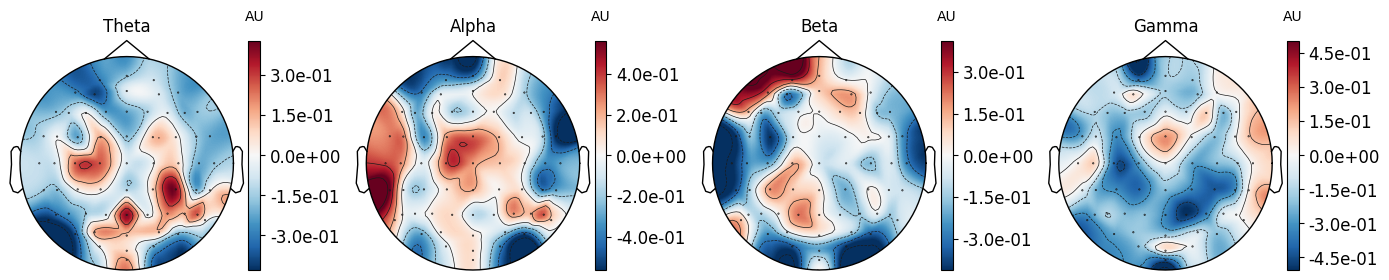

In [20]:
power = power_diff

fig, axes = plt.subplots(1, 4, figsize=(14, 8))
topomap_kw = dict(ch_type='eeg', tmin=-1, tmax=0, baseline=(-1, -.75),
                  mode='logratio', show=False)
plot_dict = dict(Theta=dict(fmin=4, fmax=8), Alpha=dict(fmin=8, fmax=15), Beta=dict(fmin=15, fmax=32), Gamma=dict(fmin=32, fmax=55))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(title)
fig.tight_layout()
fig.show()



# Statistical Tests

## U-tests

In [11]:

def get_all_eeg_cols(input_df):
    rel_eeg_cols = []
    for each_region in all_regions:
        rel_eeg_cols.extend([col for col in input_df if col.startswith(each_region) and 'Power' in col])
    return rel_eeg_cols

def get_all_ts(input_df,rel_cols = None, condition=None, low_high=None):
    dct = defaultdict(dict)
    if not rel_cols:
        for x in input_df:
            for y in input_df:
                try:
                    dct[x] = {y: stats.mannwhitneyu(input_df[x], input_df[y]).pvalue}
                except TypeError:
                    pass
    else:
        for x in rel_cols:
            try:
                stat_result = stats.mannwhitneyu(input_df.loc[input_df[condition]==low_high[0],x].dropna(),
                                        input_df.loc[input_df[condition]==low_high[1],x].dropna())
                
                p_val = stat_result.pvalue
                dct[x] = [stat_result.statistic, p_val]
            except TypeError:
                pass
        return pd.DataFrame(dct,index=['stat','pvalue'])
    return pd.DataFrame(dct)


rel_eeg_cols = get_all_eeg_cols(motor_dfs)
rel_eeg_cols.extend(eye_cols)
rel_eeg_cols.extend(ecg_cols)
pupil_sigs = get_all_ts(motor_dfs,rel_cols = rel_eeg_cols,condition='pupil_bin', low_high=('low','high'))
#pupil_sigs.to_csv('pupil_sigs.csv',index=True)
motor_sigs = get_all_ts(motor_dfs,rel_cols = rel_eeg_cols,condition='Steer_Wheel_Degree_Categorical', low_high=('Low','High')) # or condition='Steer_Wheel_Degree_Categorical'
#motor_sigs.to_csv('motor_sigs.csv',index=True)


## Linear Mixed Effects Results

In [15]:
import statsmodels.formula.api as smf
# from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

results_dict = defaultdict(list)
for resp_var in ['FC3_15-32_Hz_Power','FC1_15-32_Hz_Power', 'FCz_15-32_Hz_Power', 'FC2_15-32_Hz_Power', 'FC4_15-32_Hz_Power']:
    try:
        #motor_dfs_nonnan = motor_dfs[['Left Pupil Diameter','ppid',resp_var,'Steer_Wheel_Degree_Categorical','Abs_Steer_Wheel_Degree']].dropna()
        motor_dfs_nonnan = motor_dfs[['Left Pupil Diameter','ppid',resp_var,'Abs_Steer_Wheel_Degree']].dropna()
        md = smf.mixedlm(f"Q('{resp_var}') ~ Q('Left Pupil Diameter') + Abs_Steer_Wheel_Degree + Q('Left Pupil Diameter'):Abs_Steer_Wheel_Degree",
                         motor_dfs_nonnan, groups=motor_dfs_nonnan["ppid"])
        #random = {"a": '0 + C(ppid)'}
        #md = BinomialBayesMixedGLM.from_formula("Q('FC3_4-8_Hz_Power') ~ Q('Left Pupil Diameter') + C(Steer_Wheel_Degree_Categorical) + Q('Left Pupil Diameter'):C(Steer_Wheel_Degree_Categorical)",
        #                 random, motor_dfs_nonnan)

        mdf = md.fit()
        for each_var in [i for i,v in enumerate(mdf.pvalues.values) if v < 0.05]:
            if each_var > 0 and each_var < len(mdf.pvalues)-1: # don't count first or last
                results_dict[resp_var].append(list(mdf.pvalues.index)[each_var])
        print(mdf.summary())
    except:
        pass
# pd.DataFrame(list(results_dict.values()), index=results_dict.keys()).to_csv('glm_results.csv')
pd.DataFrame(list(results_dict.values()), index=results_dict.keys())

                          Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Q('FC3_15-32_Hz_Power')
No. Observations:        2738           Method:                    REML                   
No. Groups:              10             Scale:                     0.0047                 
Min. group size:         81             Log-Likelihood:            3413.7534              
Max. group size:         723            Converged:                 Yes                    
Mean group size:         273.8                                                            
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.149    0.014 10.658 0.000  0.122  0.177
Q('Left Pupil Diameter')  

0  \
FC3_15-32_Hz_Power    Abs_Steer_Wheel_Degree   
FC1_15-32_Hz_Power  Q('Left Pupil Diameter')   
FCz_15-32_Hz_Power  Q('Left Pupil Diameter')   
FC4_15-32_Hz_Power  Q('Left Pupil Diameter')   

                                                                  1  
FC3_15-32_Hz_Power  Q('Left Pupil Diameter'):Abs_Steer_Wheel_Degree  
FC1_15-32_Hz_Power                                             None  
FCz_15-32_Hz_Power                                             None  
FC4_15-32_Hz_Power                                             None

##  Predict motor category using non-PMC, exploration-related data

In [123]:
all_vars = ['FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power',
            'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
            'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power',
            'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power','AF3_4-8_Hz_Power', 'AF3_8-15_Hz_Power', 'AF3_15-32_Hz_Power', 'AF3_32-55_Hz_Power', 'AFz_4-8_Hz_Power', 'AFz_8-15_Hz_Power',
       'AFz_15-32_Hz_Power', 'AFz_32-55_Hz_Power', 'AF4_4-8_Hz_Power', 'AF4_8-15_Hz_Power', 'AF4_15-32_Hz_Power', 'AF4_32-55_Hz_Power',
        'Left Pupil Diameter', 'NSLR_count_Fixation', 'NSLR_count_Saccade',
       'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade', 'NSLR_first_onset_Fixation',
       'NSLR_first_onset_Saccade', 'density', 'bpm', 'sdnn', 'rmssd', 'pnn50', 'ppid', 'Abs_Steer_Wheel_Degree',
            'Steer_Wheel_Degree_Encoded','Steer_Wheel_Degree','removed_beat_rate']
predictions = ['FC3_15-32_Hz_Power', 'FC1_15-32_Hz_Power', 'FCz_15-32_Hz_Power', 
            'FC2_15-32_Hz_Power', 
            'FC4_15-32_Hz_Power']
# chosen from  Boudewyn and 
predictors = ['AF3_32-55_Hz_Power', 'AFz_32-55_Hz_Power', 'AF4_32-55_Hz_Power',
              'Left Pupil Diameter','NSLR_count_Saccade','NSLR_mean_duration_Saccade', 
       'NSLR_first_onset_Saccade', 'density', 'bpm','rmssd']
motor_dfs_nonnan = motor_dfs[all_vars].dropna()
counts = defaultdict(int)
weights = defaultdict(float)
significance = defaultdict(str)
connections = {}
for p in predictions:
    md = sm.regression.mixed_linear_model.MixedLM(motor_dfs_nonnan[p],motor_dfs_nonnan[predictors],
                     groups=motor_dfs_nonnan["ppid"])
    mdf = md.fit()
    # display(mdf.summary())
    for each_sign in list(np.array(predictors)[np.where(mdf.pvalues[:-1]<0.05)]):
        round_weight = "{:.2f}".format(mdf.params[each_sign])
        found_in_dict = False
        if mdf.pvalues[each_sign] < 0.001:
            sign = '***'
        elif mdf.pvalues[each_sign] < 0.01:
            sign = '**'
        else:
            sign = '*'
        if '4-8_Hz_Power' in each_sign:
            region = 'Theta'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        elif '8-15_Hz_Power' in each_sign:
            region = 'Alpha'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        elif '15-32_Hz_Power' in each_sign:
            region = 'Beta'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        elif '32-55_Hz_Power' in each_sign:
            region = 'Gamma'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        else:
            counts[(p, each_sign)] += 1
            weights[(p, each_sign)] += mdf.params[each_sign]
            significance[(p, each_sign)] += f"{each_sign} ({round_weight}{sign}) "
    #print(f"The features that significantly predict {p} are {list(np.array(predictors)[np.where(mdf.pvalues[:-1]<0.05)])}")
counts_df = pd.DataFrame(counts,index=[0]).T.sort_values(0,ascending=False)
display(pd.DataFrame(counts,index=[0]).T)
# note that where p<0.05 we can realiably expect they have some predictive power for motor data

54.6104190111224


/opt/conda/envs/mnaa/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/envs/mnaa/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/envs/mnaa/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/envs/mnaa/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/envs/mnaa/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarni

0
FC3_15-32_Hz_Power DL-PFC Gamma              2
                   bpm                       1
                   rmssd                     1
FC1_15-32_Hz_Power DL-PFC Gamma              2
                   bpm                       1
                   rmssd                     1
FCz_15-32_Hz_Power DL-PFC Gamma              1
                   bpm                       1
                   rmssd                     1
FC2_15-32_Hz_Power DL-PFC Gamma              2
                   Left Pupil Diameter       1
                   NSLR_first_onset_Saccade  1
                   rmssd                     1
FC4_15-32_Hz_Power DL-PFC Gamma              1
                   bpm                       1
                   rmssd                     1

In [122]:
weights_df = pd.DataFrame(weights,index=[0]).T.reset_index()
sign_df = pd.DataFrame(significance,index=[0]).T.reset_index()
weights_df = weights_df.merge(sign_df,on=['level_0', 'level_1'])
weights_df = weights_df.rename(columns={'level_0': 'Prediction', 'level_1': 'Predictor Class', '0_x': 'Average Coefficient', '0_y': 'Predictor (sign.)'})
rename_dict = {'index':'measure','Abs_Steer_Wheel_Degree':'Motor intensity (deg)', 'density': 'Trial opacity',
               'NSLR_count_Saccade': 'Saccade count',
               'NSLR_mean_duration_Saccade': 'Saccade duration (ms)',
               'NSLR_first_onset_Saccade': 'First saccade (ms)',
              '_8-15_Hz_Power': ' Alpha',
               '_15-32_Hz_Power': '',
              'bpm':'BPM', 'rmssd':'RMSSD (ms)','pnn50':'PNN50','Left Pupil Diameter':'Pupil Diameter (mm)'
              }
weights_df = weights_df.replace(rename_dict, regex=True)

weights_df = weights_df[['Prediction', 'Predictor Class', 'Predictor (sign.)']]
display(weights_df)
print(weights_df.set_index(['Prediction', 'Predictor Class']).to_latex(float_format="{:0.2f}".format))

Prediction      Predictor Class               Predictor (sign.)
0         FC3         DL-PFC Gamma     AF3 (0.12**) AF4 (0.21***) 
1         FC3                  BPM                  BPM (0.00***) 
2         FC3           RMSSD (ms)          RMSSD (ms) (-0.00***) 
3         FC1         DL-PFC Gamma        AF3 (0.08*) AF4 (0.08*) 
4         FC1                  BPM                    BPM (0.00*) 
5         FC1           RMSSD (ms)            RMSSD (ms) (-0.00*) 
6         FCz         DL-PFC Gamma                  AFz (0.19***) 
7         FCz                  BPM                  BPM (0.00***) 
8         FCz           RMSSD (ms)          RMSSD (ms) (-0.00***) 
9         FC2         DL-PFC Gamma     AFz (0.13**) AF4 (0.13***) 
10        FC2  Pupil Diameter (mm)  Pupil Diameter (mm) (0.01***) 
11        FC2   First saccade (ms)    First saccade (ms) (0.02**) 
12        FC2           RMSSD (ms)            RMSSD (ms) (-0.00*) 
13        FC4         DL-PFC Gamma                  AF4 (0.21***) 
14        FC4                  BPM                  BPM (0.00***) 
15        FC4           RMSSD (ms)           RMSSD (ms) (-0.00**)

\begin{tabular}{lll}
\toprule
    &            &               Predictor (sign.) \\
Prediction & Predictor Class &                                 \\
\midrule
FC3 & DL-PFC Gamma &     AF3 (0.12**) AF4 (0.21***)  \\
    & BPM &                  BPM (0.00***)  \\
    & RMSSD (ms) &          RMSSD (ms) (-0.00***)  \\
FC1 & DL-PFC Gamma &        AF3 (0.08*) AF4 (0.08*)  \\
    & BPM &                    BPM (0.00*)  \\
    & RMSSD (ms) &            RMSSD (ms) (-0.00*)  \\
FCz & DL-PFC Gamma &                  AFz (0.19***)  \\
    & BPM &                  BPM (0.00***)  \\
    & RMSSD (ms) &          RMSSD (ms) (-0.00***)  \\
FC2 & DL-PFC Gamma &     AFz (0.13**) AF4 (0.13***)  \\
    & Pupil Diameter (mm) &  Pupil Diameter (mm) (0.01***)  \\
    & First saccade (ms) &    First saccade (ms) (0.02**)  \\
    & RMSSD (ms) &            RMSSD (ms) (-0.00*)  \\
FC4 & DL-PFC Gamma &                  AF4 (0.21***)  \\
    & BPM &                  BPM (0.00***)  \\
    & RMSSD (ms) &           RMS

##  Predict motor intensity using PMC, exploitation-related data

In [8]:

all_vars = ['FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power',
            'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
            'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power',
            'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power','Abs_Steer_Wheel_Degree','ppid',
            'Left Pupil Diameter','NSLR_mean_duration_Saccade','NSLR_count_Saccade','bpm','rmssd','pnn50',
            'Steer_Wheel_Degree_Encoded','Steer_Wheel_Degree']
predictors = ['FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power',
            'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
            'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power',
            'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power',
             'Left Pupil Diameter','NSLR_mean_duration_Saccade','NSLR_count_Saccade','bpm','rmssd','pnn50',]
motor_dfs_nonnan = motor_dfs[all_vars].dropna()
md = sm.regression.mixed_linear_model.MixedLM(motor_dfs_nonnan['Abs_Steer_Wheel_Degree'],motor_dfs_nonnan[predictors],
                 groups=motor_dfs_nonnan["ppid"])
mdf = md.fit()
display(mdf.summary())
print(f"The features that significantly predict motor intensity are {list(np.array(predictors)[np.where(mdf.pvalues[:-1]<0.05)])}")

# note that where p<0.05 we can realiably expect they have some predictive power for motor data

/opt/conda/envs/mnaa/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:             MixedLM Dependent Variable: Abs_Steer_Wheel_Degree
No. Observations:  916     Method:             REML                  
No. Groups:        10      Scale:              0.0149                
Min. group size:   11      Log-Likelihood:     573.6845              
Max. group size:   193     Converged:          Yes                   
Mean group size:   91.6                                              
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
FC3_4-8_Hz_Power           -0.071    0.109 -0.650 0.515 -0.284  0.142
FC3_8-15_Hz_Power          -0.037    0.148 -0.253 0.800 -0.327  0.252
FC3_15-32_Hz_Power          0.130    0.120  1.085 0.278 -0.105  0.365
FC3_32-55_Hz_Power         -0.184    0.087 -2.103 0.035 -0.355 -0.012
FC1_4-8_Hz_Power            0.051    0.120  0.424 0.672 -0.184  0.286
FC1_8-15_Hz_Power           0.127    0.167  0.759 0.448 -0.201  0.455
FC1_15-32_Hz_Power         -0.173    0.166 -1.048 0.295 -0.498  0.151
FC1_32-55_Hz_Power          0.111    0.153  0.726 0.468 -0.188  0.410
FCz_4-8_Hz_Power           -0.192    0.117 -1.644 0.100 -0.422  0.037
FCz_8-15_Hz_Power           0.174    0.156  1.115 0.265 -0.132  0.481
FCz_15-32_Hz_Power         -0.030    0.186 -0.159 0.873 -0.394  0.335
FCz_32-55_Hz_Power         -0.062    0.212 -0.293 0.769 -0.477  0.353
FC2_4-8_Hz_Power            0.226    0.124  1.832 0.067 -0.016  0.468
FC2_8-15_Hz_Power          -0.368    0.157 -2.344 0.019 -0.677 -0.060
FC2_15-32_Hz_Power          0.095    0.154  0.614 0.539 -0.208  0.398
FC2_32-55_Hz_Power          0.134    0.142  0.946 0.344 -0.144  0.413
FC4_4-8_Hz_Power            0.047    0.117  0.404 0.686 -0.183  0.277
FC4_8-15_Hz_Power           0.094    0.133  0.708 0.479 -0.167  0.356
FC4_15-32_Hz_Power          0.032    0.099  0.321 0.748 -0.162  0.225
FC4_32-55_Hz_Power         -0.049    0.081 -0.603 0.547 -0.208  0.110
Left Pupil Diameter         0.036    0.006  5.618 0.000  0.023  0.049
NSLR_mean_duration_Saccade  0.059    0.069  0.862 0.389 -0.076  0.194
NSLR_count_Saccade         -0.002    0.004 -0.448 0.654 -0.010  0.006
bpm                         0.000    0.000  0.937 0.349 -0.000  0.001
rmssd                       0.000    0.000  0.022 0.983 -0.000  0.000
pnn50                      -0.024    0.034 -0.715 0.475 -0.090  0.042
Group Var                   0.001    0.004                           
=====================================================================

"""

The features that significantly predict motor intensity are ['FC3_32-55_Hz_Power', 'FC2_8-15_Hz_Power', 'Left Pupil Diameter']


## Correlation analysis

In [18]:
motor_dfs_corr = motor_dfs[['Left Pupil Diameter','NSLR_mean_duration_Saccade','NSLR_count_Saccade','Abs_Steer_Wheel_Degree','density',
                            'bpm','rmssd','pnn50',
                            'FC3_8-15_Hz_Power','FC1_8-15_Hz_Power', 'FCz_8-15_Hz_Power','FC2_8-15_Hz_Power','FC4_8-15_Hz_Power',
                            'FC3_15-32_Hz_Power', 'FC1_15-32_Hz_Power', 'FCz_15-32_Hz_Power', 'FC2_15-32_Hz_Power', 'FC4_15-32_Hz_Power']].dropna()
motor_dfs_corr['NSLR_mean_duration_Saccade'] *= 1000
motor_dfs_corr['Abs_Steer_Wheel_Degree'] *= 100
rho = motor_dfs_corr.corr(method='spearman')
pval = motor_dfs_corr.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho_df = rho.round(2).astype(str) + p
rename_dict = {'index':'measure','Abs_Steer_Wheel_Degree':'Motor intensity (deg)', 'density': 'Trial opacity',
               'NSLR_count_Saccade': 'Saccade count',
               'NSLR_mean_duration_Saccade': 'Saccade duration (ms)',
              '_8-15_Hz_Power': ' Alpha',
               '_15-32_Hz_Power': ' Beta',
              'bpm':'BPM', 'rmssd':'RMSSD (ms)','pnn50':'PNN50','Left Pupil Diameter':'Pupil Diameter (mm)'
              }
rho_df = rho_df.reset_index().rename(columns=rename_dict).iloc[:,:9]
rho_df['measure'] = rho_df.measure.replace(rename_dict, regex=True)
rho_df = rho_df.append({'measure':'mean' ,'Saccade duration (ms)': np.mean(motor_dfs_corr.NSLR_mean_duration_Saccade),
               'Saccade count': np.mean(motor_dfs_corr.NSLR_count_Saccade),
              'Trial opacity': np.mean(motor_dfs_corr.density),
               'Motor intensity (deg)': np.mean(motor_dfs_corr.Abs_Steer_Wheel_Degree),
                        'BPM': np.mean(motor_dfs_corr.bpm),
                        'RMSSD (ms)': np.mean(motor_dfs_corr.rmssd),
                        'PNN50': np.mean(motor_dfs_corr.pnn50),
                        'Pupil Diameter (mm)': np.mean(motor_dfs_corr['Left Pupil Diameter'])
              },ignore_index=True)

print(rho_df.to_latex(index=False,float_format="{:0.2f}".format))

measure Pupil Diameter (mm) Saccade duration (ms)  \
0     Pupil Diameter (mm)              1.0***                 -0.02   
1   Saccade duration (ms)               -0.02                1.0***   
2           Saccade count                0.01                 -0.06   
3   Motor intensity (deg)              0.09**                 -0.02   
4           Trial opacity               -0.03                  0.05   
5                     BPM             0.23***                  -0.0   
6              RMSSD (ms)            -0.18***                 -0.06   
7                   PNN50            -0.14***                 -0.04   
8               FC3 Alpha            -0.11***                 -0.04   
9               FC1 Alpha            -0.15***                  0.03   
10              FCz Alpha               -0.01                  0.04   
11              FC2 Alpha              -0.1**                 -0.05   
12              FC4 Alpha            -0.16***                -0.1**   
13               FC3 Beta                -0.0                  -0.0   
14               FC1 Beta            -0.21***                 0.08*   
15               FCz Beta              -0.1**                  0.06   
16               FC2 Beta               -0.04                   0.0   
17               FC4 Beta             0.13***                  -0.0   
18                   mean             2.92691             77.119319   

   Saccade count Motor intensity (deg) Trial opacity        BPM RMSSD (ms)  \
0           0.01                0.09**         -0.03    0.23***   -0.18***   
1          -0.06                 -0.02          0.05       -0.0      -0.06   
2         1.0***                 -0.05          0.02      0.07*   -0.12***   
3          -0.05                1.0***          -0.0       0.02       0.05   
4           0.02                  -0.0        1.0***      -0.05      0.07*   
5          0.07*                  0.02         -0.05     1.0***   -0.31***   
6       -0.12***                  0.05         0.07*   -0.31***     1.0***   
7       -0.12***                  0.02         0.07*   -0.37***    0.91***   
8          -0.04                  0.04         -0.05     -0.08*     0.09**   
9          -0.01                  0.01         -0.02      -0.02      -0.01   
10          0.05                 -0.01         -0.02       0.03     -0.07*   
11         -0.04                  0.01          0.01   -0.12***     0.09**   
12        -0.07*                  0.03          0.01   -0.16***     0.2***   
13          0.04                 -0.03         -0.05    0.15***      -0.04   
14          0.06                 -0.06         -0.01      0.07*      -0.02   
15         0.08*                 -0.02         -0.01       0.06     -0.07*   
16          0.03                  0.03         -0.01       0.02      -0.02   
17          0.02                  0.04        -0.08*    0.27***   -0.13***   
18      1.351528             12.360422      0.420644  84.135922  56.987924   

       PNN50  
0   -0.14***  
1      -0.04  
2   -0.12***  
3       0.02  
4      0.07*  
5   -0.37***  
6    0.91***  
7     1.0***  
8      0.08*  
9      -0.03  
10    -0.08*  
11      0.06  
12   0.17***  
13    -0.07*  
14     -0.03  
15    -0.07*  
16     -0.03  
17  -0.17***  
18  0.212072

## GLMM Results (to-do after q's)

In [199]:
import statsmodels.api as sm                                                                               
poiss_model = sm.PoissonBayesMixedGLM(                                                                    
               motor_dfs_nonnan[resp_var], # endog                                              
               motor_dfs_nonnan[['Abs_Steer_Wheel_Degree','Left Pupil Diameter']], # exog                                      
               pd.get_dummies(motor_dfs_nonnan['ppid']), # Array of covariates for the random
               [0]*len(motor_dfs_nonnan['ppid'].unique())) # ident, columns of exog_vc                         
poiss_result = poiss_model.fit_vb()     
poiss_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Poisson Mixed GLM Results
=====================================================================
                       Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------------------------
Abs_Steer_Wheel_Degree    M    -0.1125   0.1628                      
Left Pupil Diameter       M    -0.0030   0.0089                      
VC_1                      V     0.4742   0.2135 1.607   1.048   2.462
=====================================================================
Parameter types are mean structure (M) and variance structure (V)
Variance parameters are modeled as log standard deviations
"""

# Plots

trial_avg_low 20723.564251161715 diff motor-trial -2875.393005669175 pval diff w/ motor 4.0890386565522114e-10
trial_avg_high 17734.773491124222 diff motor-trial 1084.3093851258127 pval diff w/ motor 0.07202680411355418
motor low 20723.564251161715 motor high 17734.773491124222 diff -2988.790760037493
pupil low 17848.17124549254 motor high 18819.082876250035 diff 970.911630757495
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=356 | *** | n=250
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=149 | ns | n=131
trial_avg_low 17550.17903903155 diff motor-trial 468.85167564212315 pval diff w/ motor 0.4025017669653097
trial_avg_high 16882.6143799426 diff motor-trial 1560.7221809368566 pval diff w/

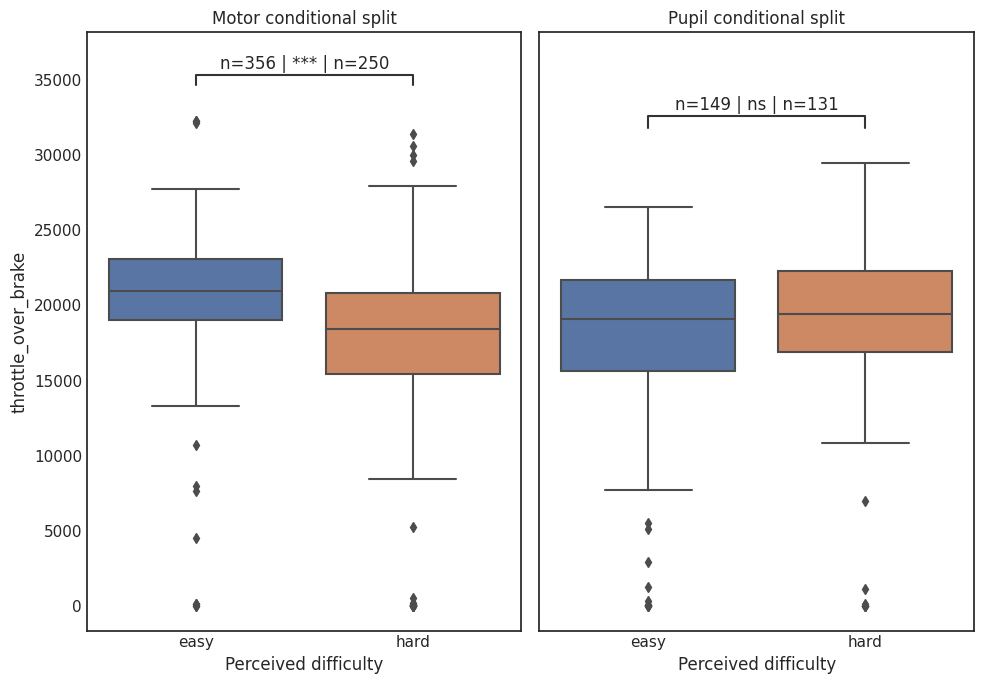

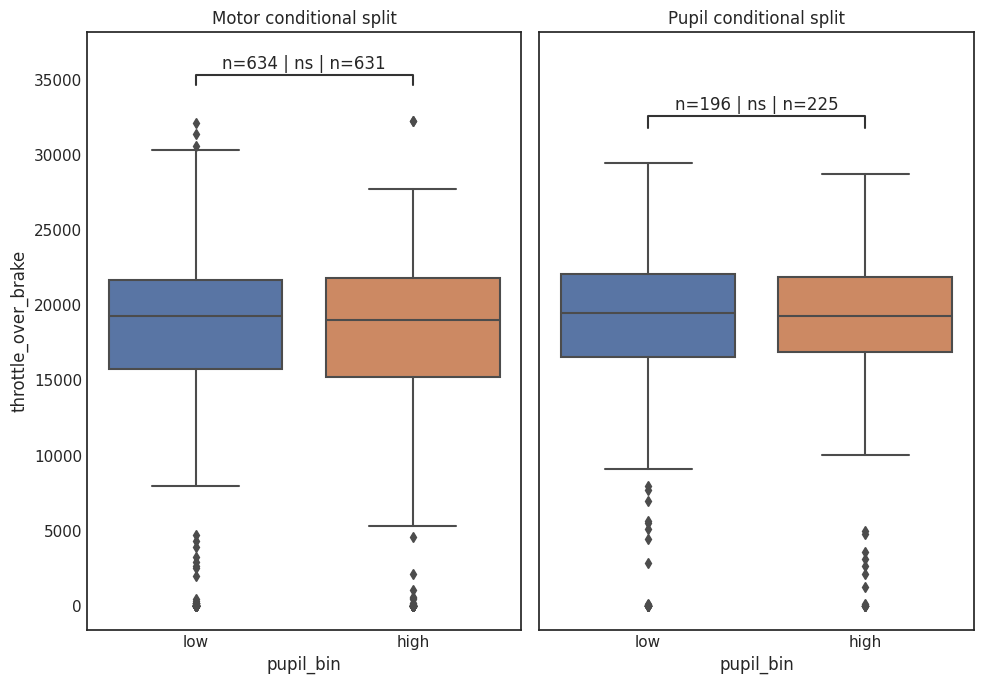

In [48]:
%matplotlib inline

sns.set(font_scale=1)
plt.style.use('seaborn-white')

def compare_motor_trial(trial_dfs, motor_dfs, y, x, x2=None, x2_order = None, x2_label=None, order=None, ylabel=None, xlabel=None, plot_type='boxplot',fill_na='nan'):
    trial_dfs_cp = trial_dfs.copy()
    motor_dfs_cp = motor_dfs.copy()
    if not x2:
        x2 = x
        x2_order = order
        x2_label = xlabel
    if fill_na == 'nan':
        ax1_plotting_parameters = {
            'data':    trial_dfs_cp,
            'x':       x,
            'y':       y,
            'order': order
        }
        ax2_plotting_parameters = {
            'data':    motor_dfs_cp,
            'x':       x2,
            'y':       y,
            'order': x2_order
        }
    else:
        trial_dfs_cp[y] = trial_dfs_cp[y].fillna(fill_na)
        motor_dfs_cp[y] = motor_dfs_cp[y].fillna(fill_na)
        ax1_plotting_parameters = {
                'data':    trial_dfs_cp,
                'x':       x,
                'y':       y,
                'order': order
            }
        ax2_plotting_parameters = {
            'data':    motor_dfs_cp,
            'x':       x2,
            'y':       y,
            'order': x2_order
        }
    stat_results = defaultdict(list)
    formatted_pvalues = defaultdict(list)
    relevant_axis = ax1_plotting_parameters
    this_df = relevant_axis['data']
    this_x = relevant_axis['x']
    this_y = relevant_axis['y']
    found_in_trial = True
    if this_x in this_df:
        if fill_na == 'nan':
            ax1_low = this_df.loc[(this_df[this_x] ==  order[0]),  this_y].dropna().values
            ax1_high = this_df.loc[(this_df[this_x] ==  order[1]),  this_y].dropna().values
        else:
            ax1_low = this_df.loc[(this_df[this_x] ==  order[0]),  this_y].fillna(fill_na).values
            ax1_high = this_df.loc[(this_df[this_x] ==  order[1]),  this_y].fillna(fill_na).values
    else:
        found_in_trial = False
        if fill_na == 'nan':
            ax1_high = this_df.loc[:,  this_y].dropna().values
        else:
            ax1_high = this_df.loc[:,  this_y].fillna(fill_na).values
    relevant_axis = ax2_plotting_parameters
    this_df = relevant_axis['data']
    this_x = relevant_axis['x']
    this_y = relevant_axis['y']
    if fill_na == 'nan':
        ax2_low = this_df.loc[(this_df[this_x] ==  x2_order[0]),  this_y].dropna().values
        ax2_high = this_df.loc[(this_df[this_x] ==  x2_order[1]),  this_y].dropna().values
    else:
        ax2_low = this_df.loc[(this_df[this_x] ==  x2_order[0]),  this_y].fillna(fill_na).values
        ax2_high = this_df.loc[(this_df[this_x] ==  x2_order[1]),  this_y].fillna(fill_na).values
    if found_in_trial:
        print('trial_avg_low', np.nanmean(ax1_low), 'diff motor-trial', np.nanmean(ax2_low)-np.nanmean(ax1_low),'pval diff w/ motor', stats.ttest_ind(ax1_low, ax2_low, alternative="two-sided").pvalue)
    print('trial_avg_high', np.nanmean(ax1_high), 'diff motor-trial', np.nanmean(ax2_high)-np.nanmean(ax1_high),'pval diff w/ motor', stats.ttest_ind(ax1_high, ax2_high, alternative="two-sided").pvalue)
    print('motor low', np.nanmean(ax1_low), 'motor high', np.nanmean(ax1_high), 'diff', np.nanmean(ax1_high)-np.nanmean(ax1_low))
    print('pupil low', np.nanmean(ax2_low), 'motor high', np.nanmean(ax2_high), 'diff', np.nanmean(ax2_high)-np.nanmean(ax2_low))
    if found_in_trial:
        stat_results['ax1'].append(stats.mannwhitneyu(ax1_low, ax1_high, alternative="two-sided").pvalue)
    stat_results['ax2'].append(stats.mannwhitneyu(ax2_low, ax2_high, alternative="two-sided").pvalue)
    def map_p_to_star(p):
        if p <= 1.00e-03:
            return '***'
        elif p <= 1.00e-02:
            return '**'
        elif p <= 5.00e-02:
            return '*'
        else:
            return 'ns'
    if found_in_trial:
        formatted_pvalues['ax1'] = [f'n={len(ax1_low)} | {map_p_to_star(pvalue)} | n={len(ax1_high)}' for pvalue in stat_results['ax1']]
    #formatted_pvalues['ax2'] = [f'n={len(ax2_low)} | p={pvalue:.2e} | n={len(ax2_high)}' for pvalue in stat_results['ax2']]
    formatted_pvalues['ax2'] = [f'n={len(ax2_low)} | {map_p_to_star(pvalue)} | n={len(ax2_high)}' for pvalue in stat_results['ax2']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7), sharey=True)
    if plot_type == 'boxplot':
        if found_in_trial:
            sns.boxplot(**ax1_plotting_parameters, ax=ax1)
        else:
            sns.boxplot(**{
                'data':    trial_dfs_cp,
                'y':       y
            }, ax=ax1)
        sns.boxplot(**ax2_plotting_parameters, ax=ax2)
    elif plot_type == 'stripplot':
        if found_in_trial:
            sns.stripplot(**ax1_plotting_parameters, ax=ax1)
        else:
            sns.stripplot(**{
                'data':    trial_dfs_cp,
                'y':       y
            }, ax=ax1)
        sns.stripplot(**ax2_plotting_parameters, ax=ax2)
    elif plot_type == 'barplot':
        if found_in_trial:
            sns.barplot(**ax1_plotting_parameters, ax=ax1)
        else:
            sns.barplot(**{
                'data':    trial_dfs_cp,
                'y':       y,
            }, ax=ax1)
        sns.barplot(**ax2_plotting_parameters, ax=ax2)
    ax1.set_title("Motor conditional split")
    ax2.set_title("Pupil conditional split")
    ax2.set(ylabel=None)
    
    if xlabel:
        if found_in_trial:
            ax1.set(xlabel=xlabel)
        ax2.set(xlabel=x2_label)
    if ylabel:
        ax1.set(ylabel=ylabel)

    # add stats
    if found_in_trial:
        annotator = Annotator(ax1, [(order[0],order[1])], **ax1_plotting_parameters)
        annotator.set_custom_annotations(formatted_pvalues['ax1'])
        annotator.annotate()
    #annotator.configure(text_format="simple")
    #annotator.set_pvalues_and_annotate(stat_results['ax1'])
    
    
    annotator = Annotator(ax2, [(x2_order[0],x2_order[1])], **ax2_plotting_parameters)
    annotator.set_custom_annotations(formatted_pvalues['ax2'])
    annotator.annotate()
    #annotator.configure(text_format="simple")
    #annotator.set_pvalues_and_annotate(stat_results['ax2'])

    fig.tight_layout()
    
    #g = sns.distplot(data=trial_dfs_cp, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Trial', fontsize=20)
    
    #g = sns.distplot(data=motor_dfs_cp, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Preceding Motor Events', fontsize=20)
    

compare_motor_trial(trial_dfs, motor_dfs[motor_dfs.throttle_over_brake>0], y='throttle_over_brake', x='spoken_difficulty', xlabel='Perceived difficulty', order=['easy','hard'])
compare_motor_trial(trial_dfs, motor_dfs[motor_dfs.throttle_over_brake>0], y='throttle_over_brake', x='pupil_bin', order=['low','high'])

## Eye tracking 

### Pupil diameter correspond with motor intensity?

trial_avg_low 2.8801114642703878 diff motor-trial -0.2496105926199581 pval diff w/ motor 8.882836474295005e-35
trial_avg_high 2.956626476148594 diff motor-trial 0.2517461712891871 pval diff w/ motor 1.9935451623719554e-21
motor low 2.8801114642703878 motor high 2.956626476148594 diff 0.07651501187820609
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low vs. High: n=1361 | ** | n=1377
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: n=1373 | *** | n=1365


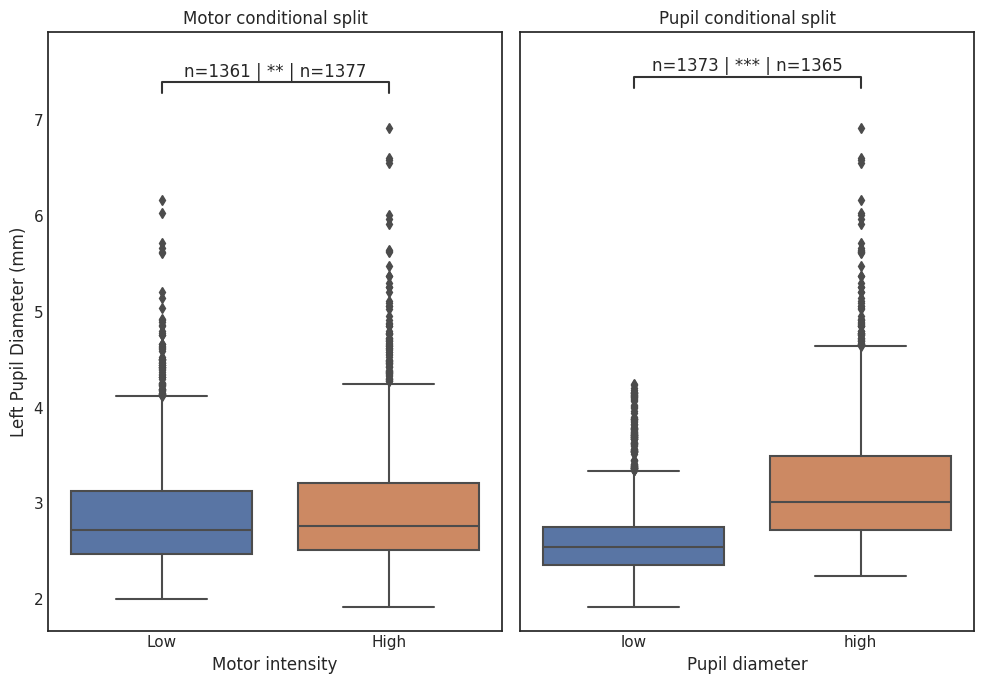

In [23]:
compare_motor_trial(motor_dfs, motor_dfs, y='Left Pupil Diameter', x='Steer_Wheel_Degree_Categorical',
                    ylabel='Left Pupil Diameter (mm)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')


### ET Markers

trial_avg_low 0.07716856783350598 diff motor-trial 0.001917304718982188 pval diff w/ motor 0.5289264943359973
trial_avg_high 0.07861925109312423 diff motor-trial -0.0033446484654434394 pval diff w/ motor 0.3054431818583783
motor low 0.07716856783350598 motor high 0.07861925109312423 diff 0.0014506832596182517
pupil low 0.07908587255248817 motor high 0.07527460262768079 diff -0.0038112699248073756
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low vs. High: n=988 | ns | n=1060
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: n=543 | * | n=556


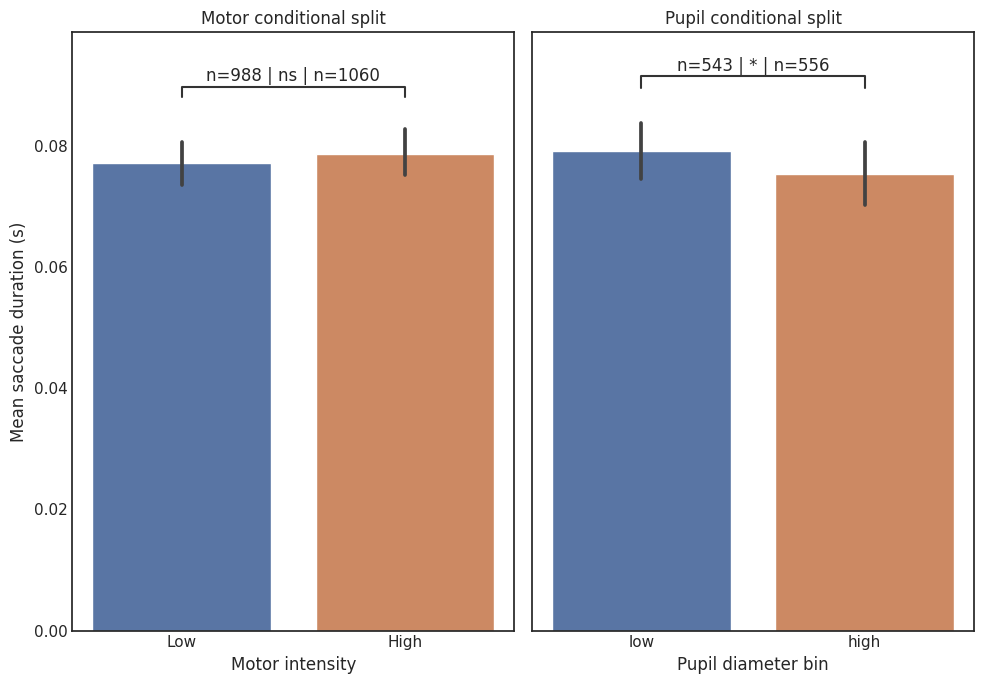

In [49]:
compare_motor_trial(motor_dfs, motor_dfs, y='NSLR_mean_duration_Saccade', x='Steer_Wheel_Degree_Categorical', 
                    ylabel='Mean saccade duration (s)', xlabel='Motor intensity', order=['Low','High'], plot_type='barplot',
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')
#compare_motor_trial(trial_dfs, motor_dfs, y='NSLR_mean_duration_Saccade', x='pupil_bin', 
#                    ylabel='Mean saccade duration (s)', xlabel='Pupil diameter', order=['low','high'], plot_type='barplot')

trial_avg_low 1.3350202429149798 diff motor-trial -0.027469598347760638 pval diff w/ motor 0.5219963575962272
trial_avg_high 1.308490566037736 diff motor-trial 0.06381159223564525 pval diff w/ motor 0.1870943879891263
motor low 1.3075506445672191 motor high 1.3723021582733812
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low vs. High: n=988 | ns | n=1060
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: n=543 | ns | n=556


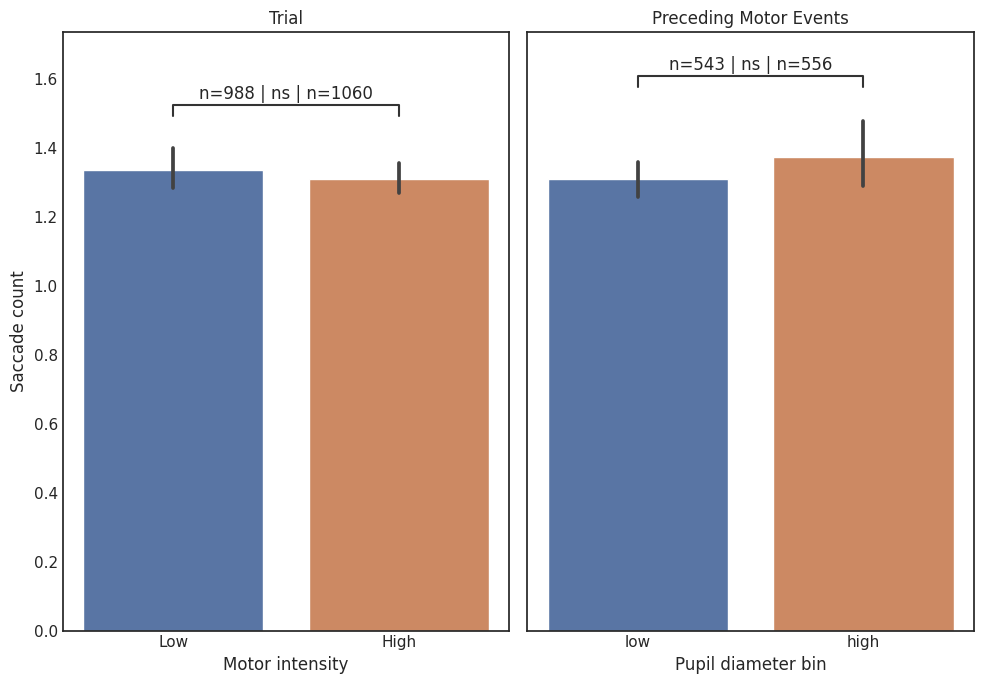

In [110]:
compare_motor_trial(motor_dfs, motor_dfs, y='NSLR_count_Saccade', x='Steer_Wheel_Degree_Categorical', 
                    ylabel='Saccade count', xlabel='Motor intensity', order=['Low','High'], plot_type='barplot',
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')


## ECG

trial_avg_low 85.19483125266748 diff motor-trial 0.9515907216374302 pval diff w/ motor 0.32029200450884004
trial_avg_high 84.91924432563387 diff motor-trial 0.4076745325852187 pval diff w/ motor 0.662036237530433
motor low 86.14642197430491 motor high 85.32691885821909
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low vs. High: n=2153 | ns | n=2133
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: n=1164 | ns | n=1201


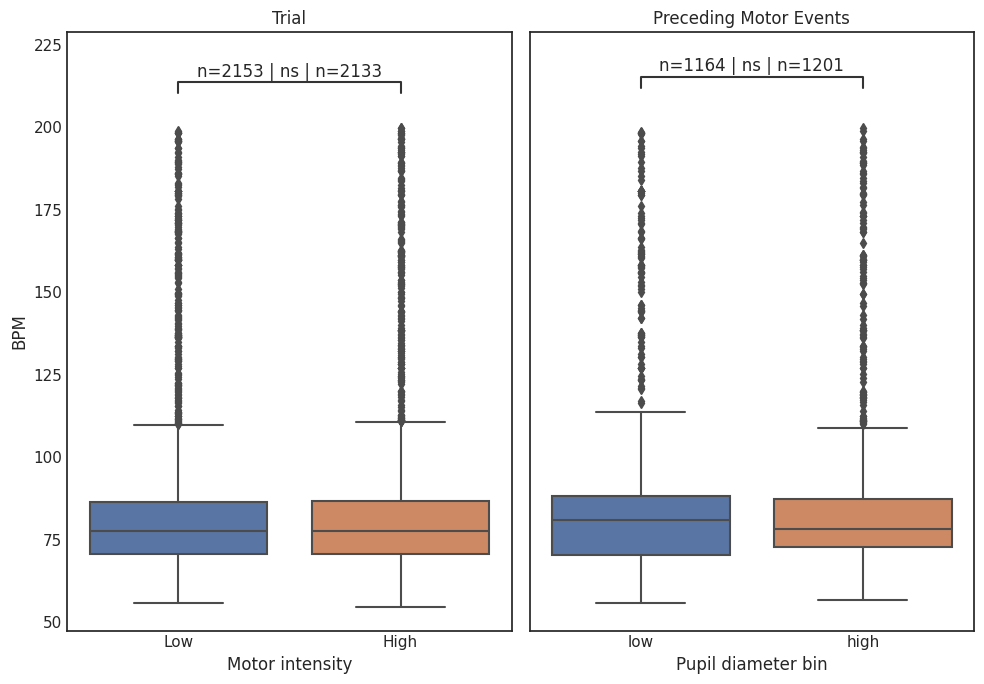

In [111]:
compare_motor_trial(motor_dfs, motor_dfs, y='bpm', x='Steer_Wheel_Degree_Categorical',
                    ylabel='BPM', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')



trial_avg_low 77.58442555797913 diff motor-trial -8.670272028461554 pval diff w/ motor 0.008119675550138247
trial_avg_high 74.27766478016817 diff motor-trial -4.6575227741309675 pval diff w/ motor 0.14037171341524715
motor low 68.91415352951758 motor high 69.6201420060372
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low vs. High: n=2269 | ns | n=2234
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: n=1222 | ns | n=1246
trial_avg_low 0.2839212038191098 diff motor-trial -0.03177832498273442 pval diff w/ motor 0.0016851455496501354
trial_avg_high 0.2768891994377819 diff motor-trial -0.029492447997308574 pval diff w/ motor 0.0020307999895527455
motor low 0.2521428788363754 motor high 0.24739675144047332
p-value a

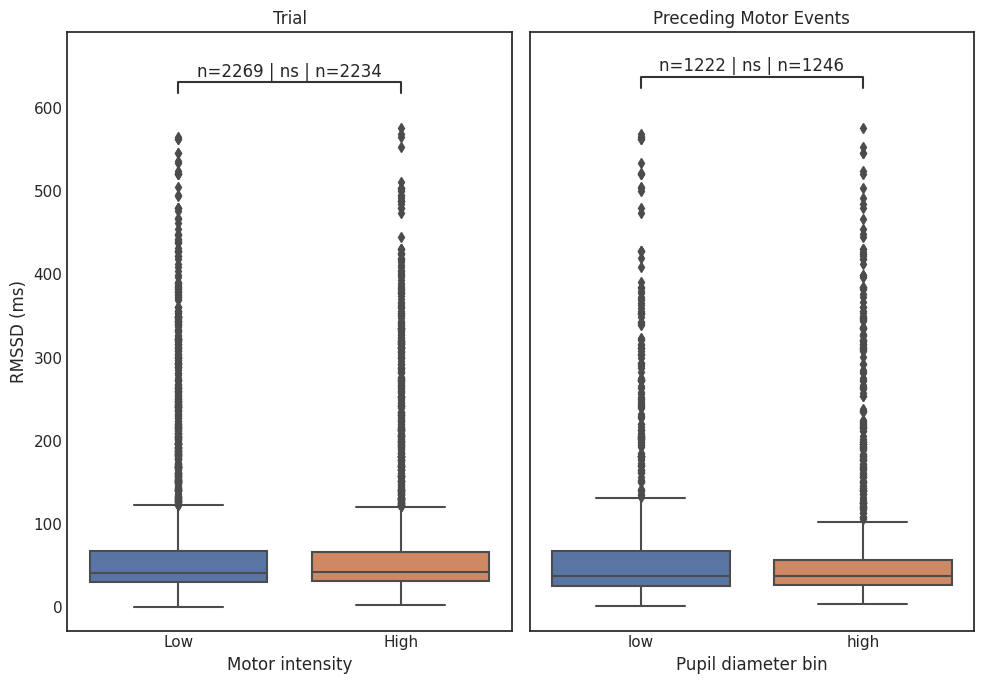

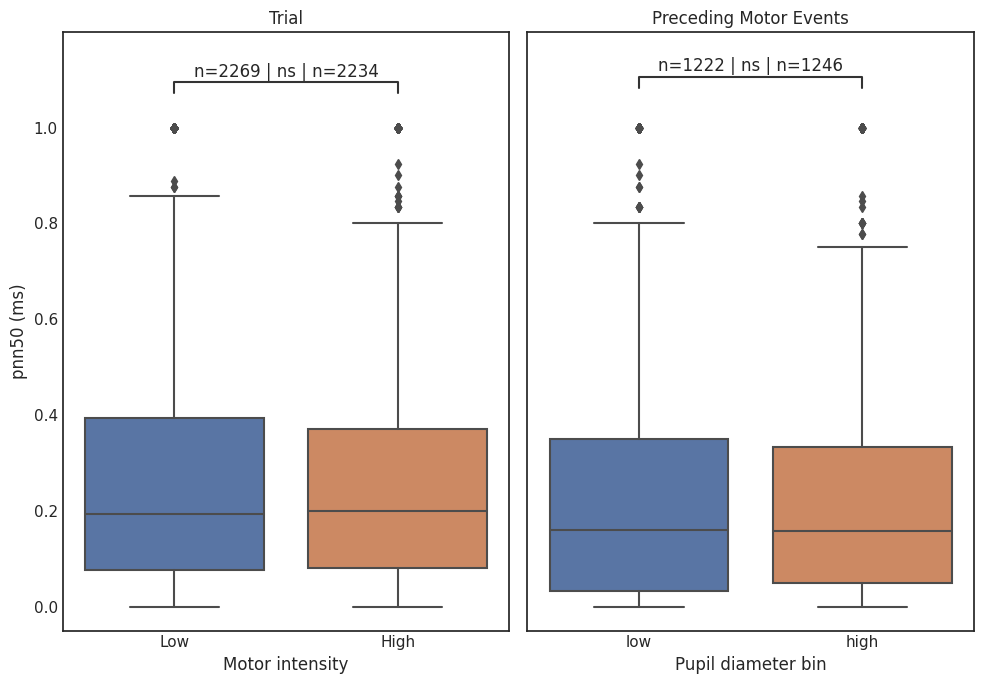

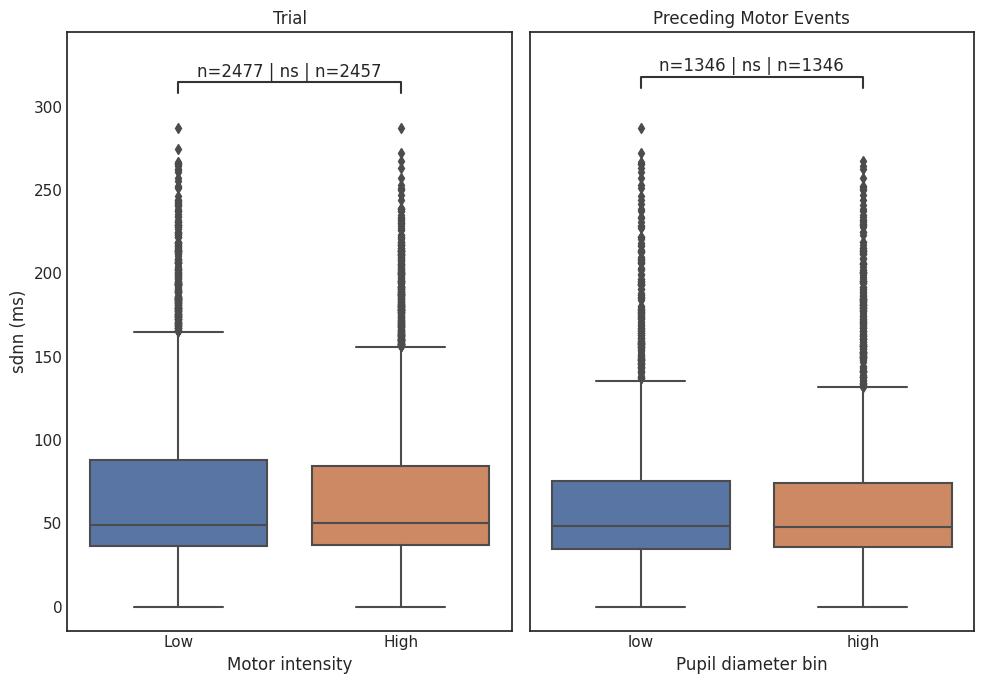

In [112]:
compare_motor_trial(motor_dfs, motor_dfs, y='rmssd', x='Steer_Wheel_Degree_Categorical',
                    ylabel='RMSSD (ms)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')

compare_motor_trial(motor_dfs, motor_dfs, y='pnn50', x='Steer_Wheel_Degree_Categorical',
                    ylabel='pnn50 (ms)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')

compare_motor_trial(motor_dfs, motor_dfs, y='sdnn', x='Steer_Wheel_Degree_Categorical',
                    ylabel='sdnn (ms)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')


## EEG

In [50]:
motor_dfs['PMC Alpha (norm)'] = np.mean(motor_dfs[['FC3_8-15_Hz_Power','FC1_8-15_Hz_Power',
                                            'FCz_8-15_Hz_Power','FC2_8-15_Hz_Power','FC4_8-15_Hz_Power']],
                                axis=1)
motor_dfs['PMC Beta (norm)'] = np.mean(motor_dfs[['FC3_15-32_Hz_Power','FC1_15-32_Hz_Power',
                                            'FCz_15-32_Hz_Power','FC2_15-32_Hz_Power','FC4_15-32_Hz_Power']],
                                axis=1)
motor_dfs['DL-PFC Beta (norm)'] = np.mean(motor_dfs[['AF3_15-32_Hz_Power','AFz_15-32_Hz_Power',
                                            'AF4_15-32_Hz_Power']],
                                axis=1)
motor_dfs['DL-PFC Alpha (norm)'] = np.mean(motor_dfs[['AF3_8-15_Hz_Power','AFz_8-15_Hz_Power',
                                            'AF4_8-15_Hz_Power']],
                                axis=1)

trial_avg_low 0.10961776736447834 diff motor-trial -0.0008429656826447474 pval diff w/ motor 0.5834194454657311
trial_avg_high 0.10874534840266818 diff motor-trial -0.008896425612463316 pval diff w/ motor 4.5863994396371305e-09
motor low 0.10961776736447834 motor high 0.10874534840266818 diff -0.0008724189618101591
pupil low 0.1087748016818336 motor high 0.09984892279020487 diff -0.008925878891628727
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low vs. High: n=2532 | ns | n=2529
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: n=1373 | *** | n=1365


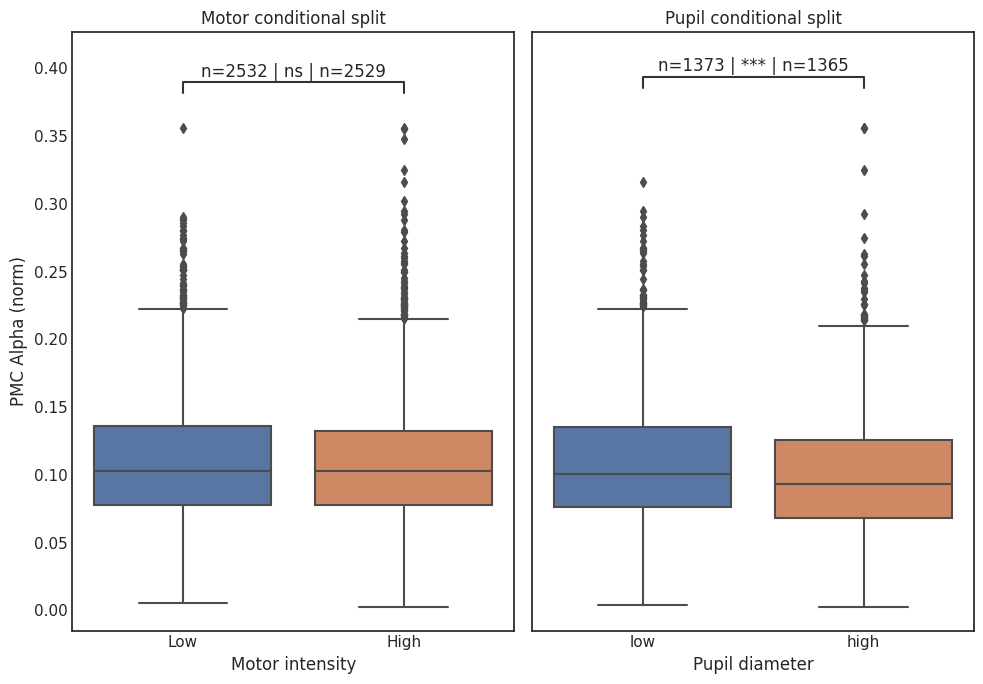

In [51]:
compare_motor_trial(motor_dfs, motor_dfs, y='PMC Alpha (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')


trial_avg_low 0.12862617807568275 diff motor-trial -0.0032608639812816698 pval diff w/ motor 0.08859591773257501
trial_avg_high 0.1256865525758264 diff motor-trial -0.0008104725236674493 pval diff w/ motor 0.6740699868739919
motor low 0.12536531409440108 motor high 0.12487608005215894
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low vs. High: n=2532 | ns | n=2529
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: n=1373 | ns | n=1365


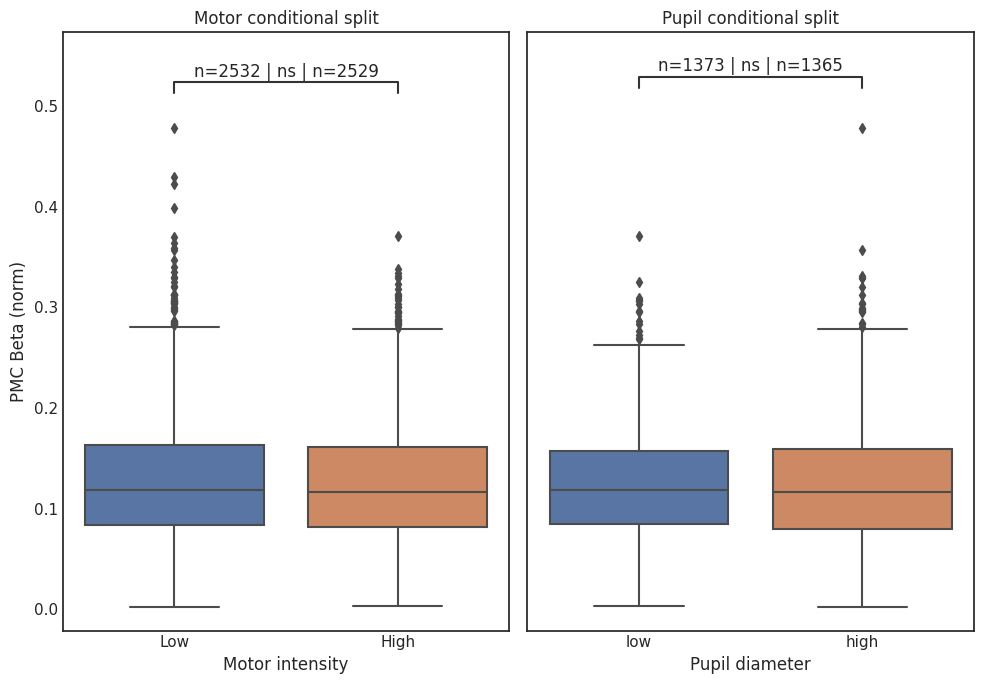

In [27]:
compare_motor_trial(motor_dfs, motor_dfs, y='PMC Beta (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')

trial_avg_low 0.08634733695994912 diff motor-trial 0.0001602782767722577 pval diff w/ motor 0.9105979700180402
trial_avg_high 0.08560842308040538 diff motor-trial -0.004383625199895838 pval diff w/ motor 0.001827760644238572
motor low 0.08650761523672137 motor high 0.08122479788050954
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low vs. High: n=2532 | ns | n=2529
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: n=1373 | ** | n=1365


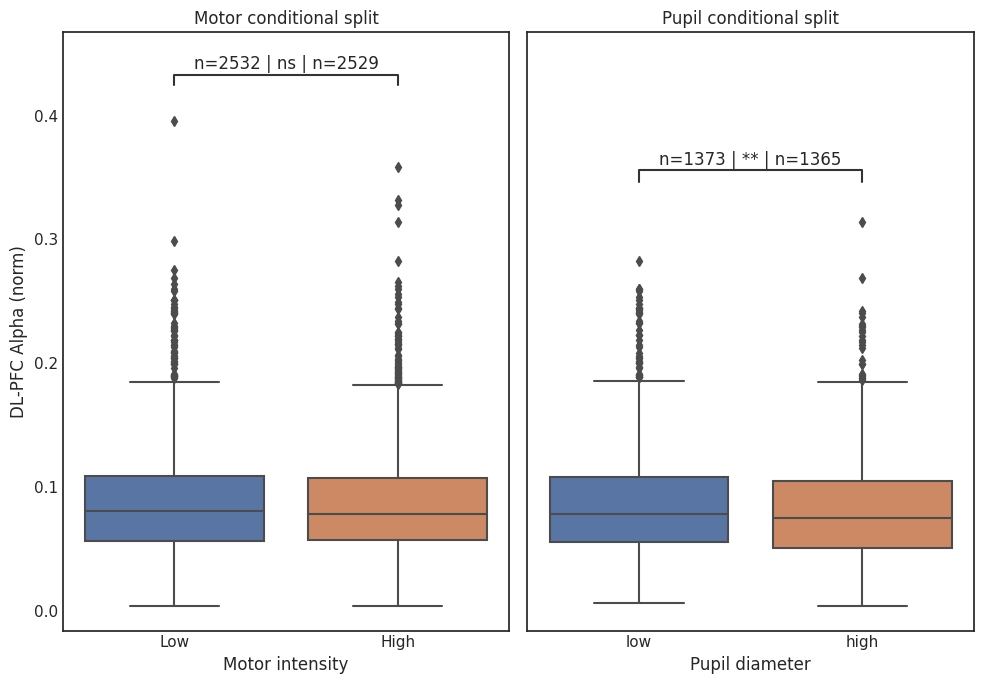

In [28]:
compare_motor_trial(motor_dfs, motor_dfs, y='DL-PFC Alpha (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')

trial_avg_low 0.13911624605719958 diff motor-trial -0.017778440305725757 pval diff w/ motor 5.036643869825465e-10
trial_avg_high 0.13646395305684275 diff motor-trial -0.014824474250012085 pval diff w/ motor 2.440621357276268e-07
motor low 0.12133780575147382 motor high 0.12163947880683067
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low vs. High: n=2532 | ns | n=2529
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: n=1373 | ns | n=1365


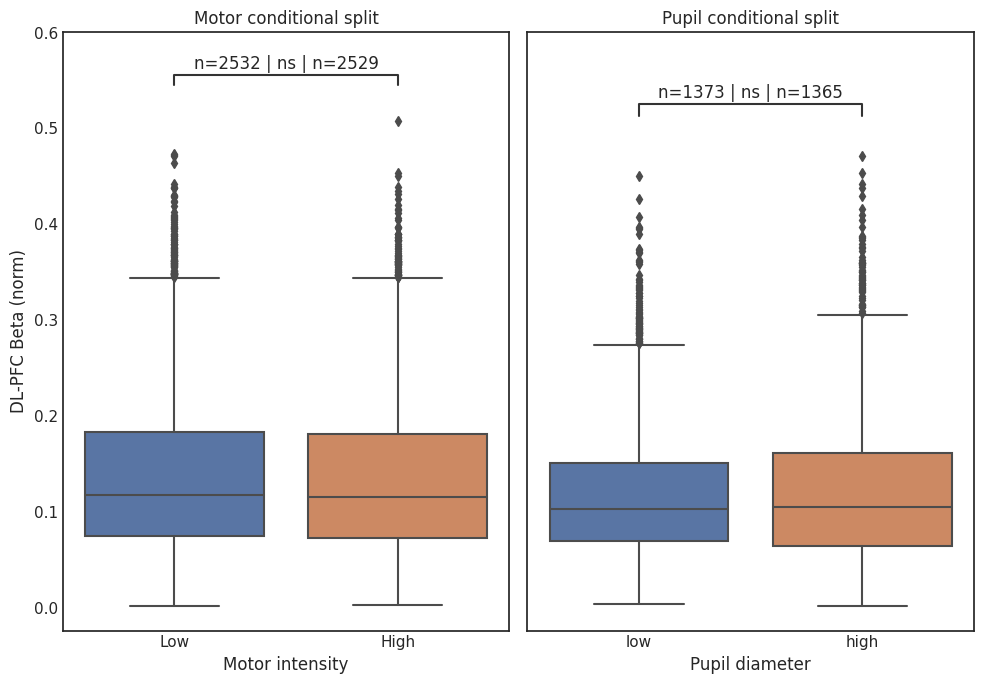

In [29]:
compare_motor_trial(motor_dfs, motor_dfs, y='DL-PFC Beta (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')

In [ ]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

epochs_easy = motor_epochs['easy']
epochs_hard = motor_epochs['hard']

#freq_range = np.logspace(*np.log10([4, 55]), num=15)
#freq_range = np.linspace(4, 56, 28)
#n_cycles = freq_range / 2.

#power_easy, itc_easy = tfr_morlet(epochs_easy, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)
#power_hard, itc_hard = tfr_morlet(epochs_hard, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)

In [ ]:
%matplotlib inline

sel_chan = power_easy.ch_names.index('FCz')
power_easy.plot([sel_chan], mode='mean', title=power_easy.ch_names[sel_chan])
power_hard.plot([sel_chan], mode='mean', title=power_hard.ch_names[sel_chan])
power_hard.plot_joint(baseline=(-1, -.75), mode='mean')

In [ ]:
%matplotlib qt
itc_easy.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds')